## Empirical Asset Pricing via Machine Learning

### Features Dataset

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('datashare.csv')

%%% This Version: April 2019. @copyright Shihao Gu, Bryan Kelly and Dacheng Xiu
%%% If you use the dataset, please cite the paper "Empirical Asset Pricing via Machine Learning" (2018) and "Autoencoder Asset Pricing Models." (2019)

Firm Characteristics Dataset Description:

1.DATE: The end day of each month (YYYYMMDD) 
2.permno: CRSP Permanent Company Number
3-96. 94 Lagged Firm Characteristics (Details are in the appendix of our paper)
97.sic2: The first two digits of the Standard Industrial Classification code on DATE

Most of these characteristics are released to the public with a delay. To avoid the forward-looking bias, we assume that monthly characteristics are delayed by at most 1 month, quarterly with at least 4 months lag, and annual with at least 6 months lag. Therefore, in order to predict returns at month t + 1, we use most recent monthly characteristics at the end of month t, most recent quarterly data by end t − 4, and most recent annual data by end t − 6. In this dataset, we've already adjusted the lags. (e.g. When DATE=19570329 in our dataset, you can use the monthly RET at 195703 as the response variable.) 

Note: CRSP returns are not included. They are accessible from WRDS.

In [3]:
df.head()

permno      DATE      mvel1      beta    betasq     chmom    dolvol  \
0   10006  19570131  82249.000  1.122846  1.260784  0.047180  9.569953   
1   10014  19570131   3903.375  0.426734  0.182102 -0.275641  6.237836   
2   10022  19570131   9273.250  1.066449  1.137313 -0.025490  7.008844   
3   10030  19570131  54465.875  0.926038  0.857547  0.018171  9.825337   
4   10057  19570131  40250.000  1.247748  1.556875  0.025785  7.901007   

    idiovol    indmom     mom1m  ...  stdcf  ms  baspread           ill  \
0  0.025742  0.046433  0.044843  ...    NaN NaN  0.013234  9.411565e-08   
1  0.072103  0.046433 -0.086957  ...    NaN NaN  0.033305  6.610609e-06   
2  0.027648  0.046433 -0.060377  ...    NaN NaN  0.016023  2.286832e-06   
3  0.021700  0.046433  0.044633  ...    NaN NaN  0.015295  1.464273e-07   
4  0.025506  0.046433  0.086667  ...    NaN NaN  0.005954  1.380375e-06   

     maxret    retvol  std_dolvol  std_turn     zerotrade  sic2  
0  0.015453  0.008058    0.355638  0.460420  1.120996e-07  37.0  
1  0.047619  0.033495    1.152126  1.169610  9.229146e-08   NaN  
2  0.020833  0.015589    0.815777  0.679803  1.181757e-07   NaN  
3  0.039326  0.015849    0.739302  1.333656  6.126699e-08   NaN  
4  0.056856  0.019945    0.755510  0.410391  3.315790e+00   NaN  

[5 rows x 97 columns]

### Merge SP500 return data from CRSP

In [ ]:
# pip install wrds

In [4]:
import wrds
conn=wrds.Connection()

Enter your WRDS username [luyifan]:yifanlu08
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [5]:
sp500 = conn.raw_sql("""
                        select a.*, b.date, b.ret
                        from crsp.msp500list as a,
                        crsp.msf as b
                        where a.permno=b.permno
                        and b.date >= a.start and b.date<= a.ending
                        and b.date>='01/01/2003'
                        order by date;
                        """, date_cols=['start', 'ending', 'date'])

In [6]:
# use the return of t+1 as target variable to avoid "look-ahead" bias
sp500['ret'] = sp500.groupby('permno')['ret'].shift(-1)
sp500

permno      start     ending       date       ret
0       11404.0 1925-12-31 2022-12-30 2003-01-31 -0.009018
1       66157.0 1995-10-23 2022-12-30 2003-01-31 -0.008531
2       81285.0 2002-05-13 2008-06-05 2003-01-31  0.027753
3       24803.0 1957-03-01 2004-12-02 2003-01-31 -0.128571
4       45356.0 1989-07-27 2009-03-16 2003-01-31 -0.075578
...         ...        ...        ...        ...       ...
120446  64311.0 1982-06-03 2022-12-30 2022-12-30       NaN
120447  90455.0 2021-02-12 2022-12-30 2022-12-30       NaN
120448  92602.0 2008-03-31 2022-12-30 2022-12-30       NaN
120449  79637.0 2014-09-22 2022-12-30 2022-12-30       NaN
120450  89003.0 2006-11-10 2022-12-30 2022-12-30       NaN

[120451 rows x 5 columns]

In [7]:
# Standardize the column names
df.columns = df.columns.str.lower()

# start date and end date of the sample
stdt, nddt = 20030101, 20211231

df = df[(df['date']>=stdt)&(df['date']<=nddt)].reset_index(drop=True)
df['date'] = pd.to_datetime(df['date'],format='%Y%m%d')+pd.offsets.MonthEnd(0)
characteristics = list(set(df.columns).difference({'permno','date','sharout','mve0','sic2','prc'}))

df.head()

permno       date          mvel1      beta    betasq     chmom     dolvol  \
0   10001 2003-01-31   19046.440565  0.029659  0.000880 -0.089410   8.227810   
1   10002 2003-01-31   96891.903330  0.150206  0.022562 -0.320835   7.890283   
2   10012 2003-01-31   28963.439900  2.366411  5.599899 -0.053419   9.596337   
3   10025 2003-01-31  103017.737590  0.284411  0.080890 -1.113467  10.503899   
4   10026 2003-01-31  317997.541850  0.344592  0.118744 -1.044593  12.615525   

    idiovol    indmom     mom1m  ...     stdcf   ms  baspread           ill  \
0  0.027213 -0.126755 -0.106149  ...  0.231362  3.0  0.025081  9.304859e-07   
1  0.057363  0.210408  0.058491  ...       NaN  5.0  0.009168  1.359763e-06   
2  0.121906 -0.265872 -0.292308  ...  0.208136  5.0  0.123509  7.811289e-07   
3  0.086661  0.060224  0.083748  ...  0.083969  4.0  0.064327  2.124187e-07   
4  0.054035 -0.026702  0.072372  ...  0.062377  6.0  0.038683  2.151544e-08   

     maxret    retvol  std_dolvol  std_turn     zerotrade  sic2  
0  0.027228  0.018782    0.997271  1.125656  7.975644e-08  49.0  
1  0.028708  0.014029    1.316328  0.164607  4.000001e+00  60.0  
2  0.135593  0.087721    0.759477  2.880852  3.081154e-08  36.0  
3  0.102944  0.044487    0.633994  1.290558  4.578640e-08  30.0  
4  0.082311  0.031521    0.669035  3.009159  2.331262e-08  20.0  

[5 rows x 97 columns]

In [8]:
# Merge the DataFrames
df = df.merge(sp500, on=['permno', 'date'])
df = df.drop(columns=['start', 'ending'])

In [9]:
df.shape

(80211, 98)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80211 entries, 0 to 80210
Data columns (total 98 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   permno           80211 non-null  int64         
 1   date             80211 non-null  datetime64[ns]
 2   mvel1            80211 non-null  float64       
 3   beta             79677 non-null  float64       
 4   betasq           79677 non-null  float64       
 5   chmom            79747 non-null  float64       
 6   dolvol           80149 non-null  float64       
 7   idiovol          79677 non-null  float64       
 8   indmom           80211 non-null  float64       
 9   mom1m            80165 non-null  float64       
 10  mom6m            79998 non-null  float64       
 11  mom12m           79747 non-null  float64       
 12  mom36m           78496 non-null  float64       
 13  pricedelay       79677 non-null  float64       
 14  turn             80123 non-null  float

In [11]:
df = df.set_index('date')

In [113]:
# df.to_csv('proj_data.csv')

## EDA ##

### Time-series Analysis of Return

In [13]:
import matplotlib.pyplot as plt

In [427]:
# Calculate the value-weighted return
df['weighted_ret'] = df['ret'] * df['mvel1']
value_weighted_ret = df['weighted_ret'].groupby(df.index).sum() / df['mvel1'].groupby(df.index).sum()
df = df.drop(columns='weighted_ret')

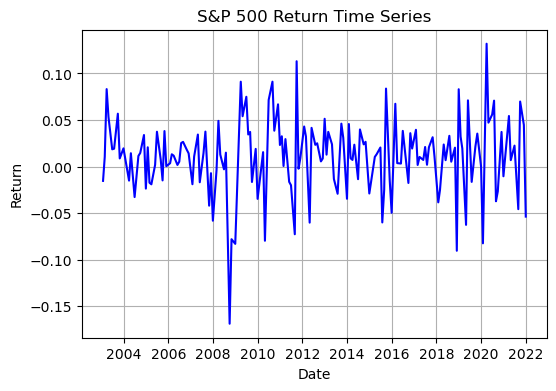

In [111]:
plt.figure(figsize=(6, 4))
plt.plot(value_weighted_ret, linestyle='-', color='b')
plt.title('S&P500 Return Time Series')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.show()

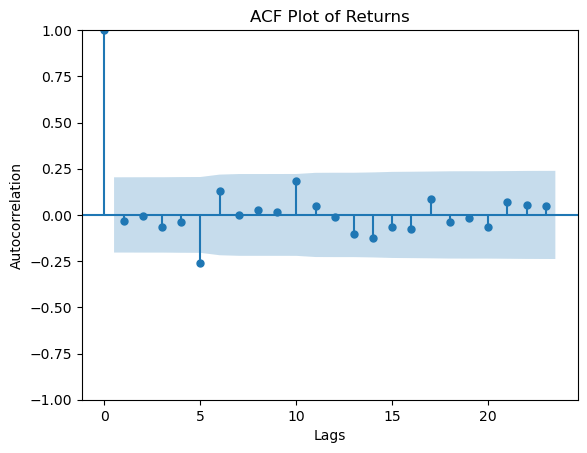

In [108]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(value_weighted_ret, alpha=0.01)  # Adjust the number of lags as needed

plt.title('ACF Plot of Returns')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

Hint: Use lag(5) return as additional feature.

In [168]:
# Create autocorrelation feature
df['ret_lag5'] = df.groupby('permno')['ret'].shift(5)

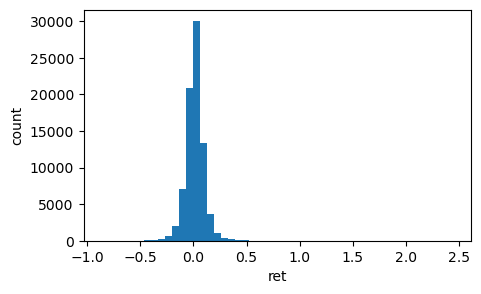

In [25]:
# return distribution
plt.figure(figsize=(5,3))

df['ret'].plot.hist(bins=50)
plt.xlabel('ret')
plt.ylabel('count')
plt.show()

### Feature Heatmap

pairwise correlation and corr. with target

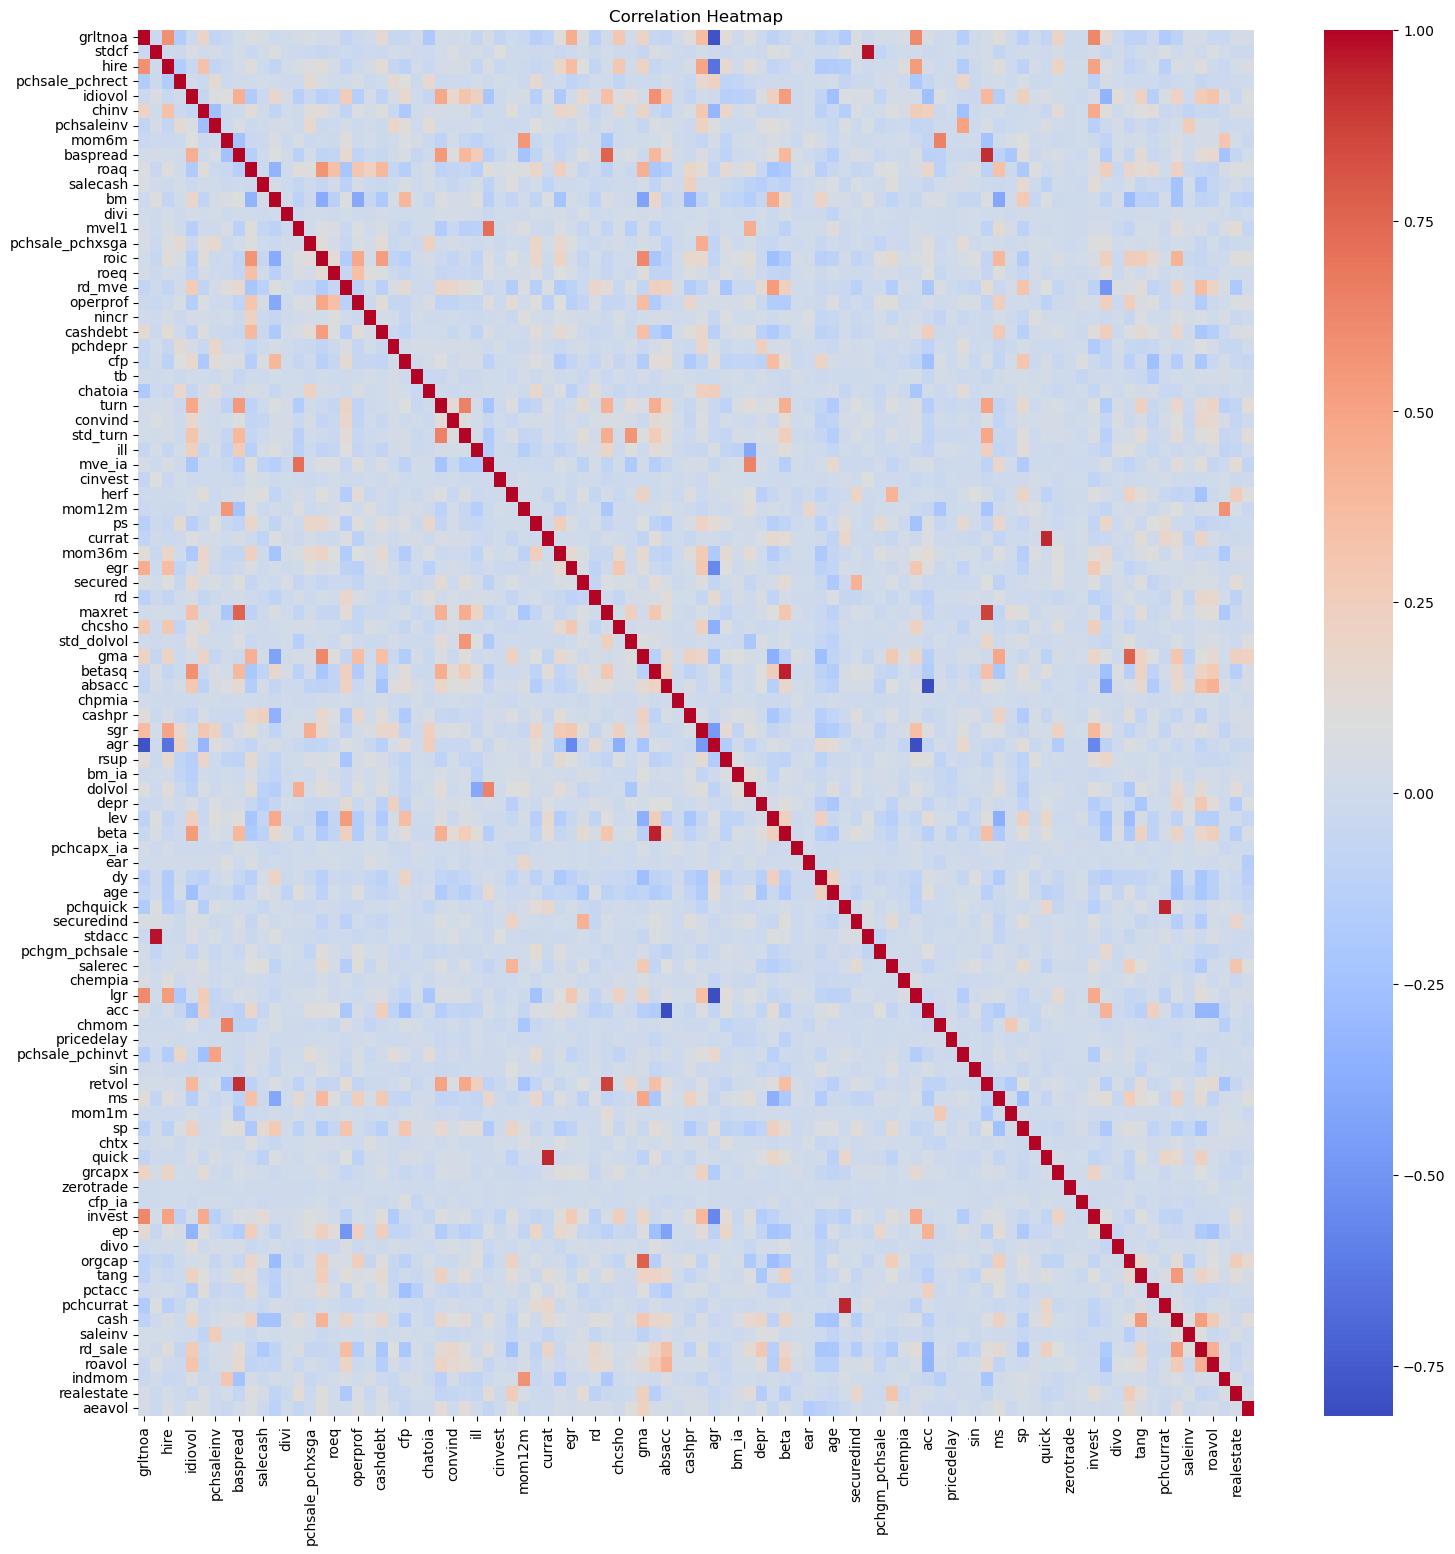

<Figure size 640x480 with 0 Axes>

In [95]:
import seaborn as sns
plt.figure(figsize = (18,18))
sns.heatmap(data=df[characteristics].corr(), cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
plt.gcf().clear()

In [115]:
# Top correlated features
c = df[characteristics].corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort").reset_index()
so.columns = ['col_1','col_2', 'corr']
so = so.sort_values(by = ['corr', 'col_1'], ascending = False)
so = so[so['corr']!=1]
so = so.iloc[::2].reset_index(drop=True)
so

col_1       col_2          corr
0          stdcf      stdacc  9.732276e-01
1         betasq        beta  9.504550e-01
2       pchquick   pchcurrat  9.490988e-01
3          quick      currat  9.427751e-01
4         retvol    baspread  9.262964e-01
...          ...         ...           ...
4366  pricedelay       mvel1  3.681792e-05
4367          dy     cinvest  1.715561e-05
4368   zerotrade  pchsaleinv  1.555841e-05
4369  pricedelay        divo  1.364881e-05
4370   zerotrade        rsup  7.347408e-07

[4371 rows x 3 columns]

In [143]:
high_corr = np.unique(so.iloc[:12,:2].unstack())

In [144]:
high_corr = np.random.permutation(high_corr)

In [145]:
high_corr = np.append(high_corr, 'ret')

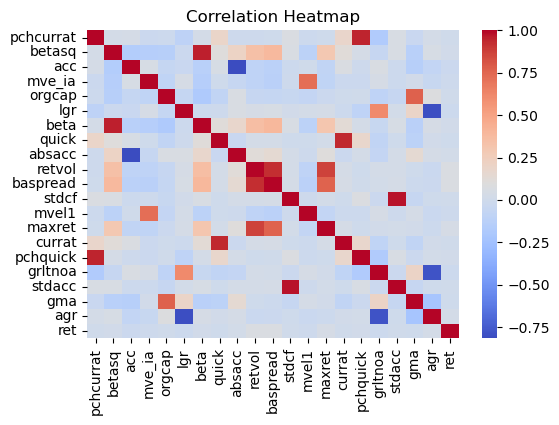

<Figure size 640x480 with 0 Axes>

In [146]:
plt.figure(figsize = (6,4))
sns.heatmap(data=df[high_corr].corr(), cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
plt.gcf().clear()

In [147]:
# Set a threshold for correlation
thres = 0.7

# Find and drop highly correlated features
high_corr1 = set()
for i in range(len(c.columns)):
    for j in range(i):
        if c.iloc[i, j] > thres:
            col = c.columns[i]
            high_corr1.add(col)
print(high_corr1)

{'agr', 'lgr', 'acc', 'pchcurrat', 'beta', 'maxret', 'orgcap', 'mve_ia', 'retvol', 'quick', 'stdacc'}


In [149]:
df = df.drop(columns=high_corr1)

In [150]:
df.head()

permno         mvel1    betasq     chmom     dolvol   idiovol  \
date                                                                        
2003-01-31   10078  9.936164e+06  3.608050  0.213441  17.586136  0.076955   
2003-01-31   10104  5.690643e+07  2.031124  0.454709  17.586136  0.081222   
2003-01-31   10107  2.766308e+08  1.254327  0.119495  17.586136  0.049207   
2003-01-31   10108  6.671226e+06  0.480190 -0.025585  15.661298  0.061650   
2003-01-31   10137  9.501862e+05  0.305354 -0.427092  14.657669  0.084573   

              indmom     mom1m     mom6m    mom12m  ...     stdcf   ms  \
date                                                ...                  
2003-01-31 -0.133079 -0.275227 -0.143513 -0.651138  ...  0.121279  5.0   
2003-01-31 -0.206804 -0.111111  0.282999 -0.120203  ...  0.542630  5.0   
2003-01-31 -0.206804 -0.103675  0.054479 -0.129358  ...  0.240719  6.0   
2003-01-31 -0.206804  0.008130 -0.117447 -0.192188  ...  0.094817  6.0   
2003-01-31 -0.126755  0.097242 -0.723644 -0.798171  ...  0.140194  2.0   

            baspread           ill  std_dolvol   std_turn     zerotrade  sic2  \
date                                                                            
2003-01-31  0.061680  1.807258e-10    0.283794   4.260413  6.113527e-09  35.0   
2003-01-31  0.053884  6.855691e-11    0.486347   3.599750  1.250209e-08  73.0   
2003-01-31  0.025686  7.918146e-12    0.363752   1.803045  1.700227e-08  73.0   
2003-01-31  0.031169  5.179282e-10    0.340125   1.424714  2.424111e-08  73.0   
2003-01-31  0.073697  2.510520e-09    0.563826  15.872721  4.650382e-09  49.0   

                 ret  weighted_ret  
date                                
2003-01-31  0.113269  1.125456e+06  
2003-01-31 -0.005819 -3.311249e+05  
2003-01-31  0.002107  5.828858e+05  
2003-01-31  0.012346  8.236073e+04  
2003-01-31 -0.286905 -2.726129e+05  

[5 rows x 87 columns]

Distribution of each feature

In [376]:
new_char = set(characteristics).difference(high_corr1)

{'absacc',
 'aeavol',
 'age',
 'baspread',
 'betasq',
 'bm',
 'bm_ia',
 'cash',
 'cashdebt',
 'cashpr',
 'cfp',
 'cfp_ia',
 'chatoia',
 'chcsho',
 'chempia',
 'chinv',
 'chmom',
 'chpmia',
 'chtx',
 'cinvest',
 'convind',
 'currat',
 'depr',
 'divi',
 'divo',
 'dolvol',
 'dy',
 'ear',
 'egr',
 'ep',
 'gma',
 'grcapx',
 'grltnoa',
 'herf',
 'hire',
 'idiovol',
 'ill',
 'indmom',
 'invest',
 'lev',
 'mom12m',
 'mom1m',
 'mom36m',
 'mom6m',
 'ms',
 'mvel1',
 'nincr',
 'operprof',
 'pchcapx_ia',
 'pchdepr',
 'pchgm_pchsale',
 'pchquick',
 'pchsale_pchinvt',
 'pchsale_pchrect',
 'pchsale_pchxsga',
 'pchsaleinv',
 'pctacc',
 'pricedelay',
 'ps',
 'rd',
 'rd_mve',
 'rd_sale',
 'realestate',
 'roaq',
 'roavol',
 'roeq',
 'roic',
 'rsup',
 'salecash',
 'saleinv',
 'salerec',
 'secured',
 'securedind',
 'sgr',
 'sin',
 'sp',
 'std_dolvol',
 'std_turn',
 'stdcf',
 'tang',
 'tb',
 'turn',
 'zerotrade'}

### Relationship with Target: scatter plot

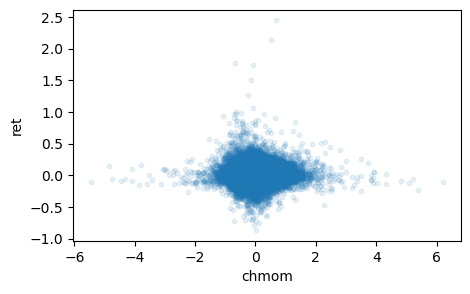

In [161]:
df.plot.scatter('chmom','ret',figsize=(5,3),alpha=0.1,s=10)
plt.show()

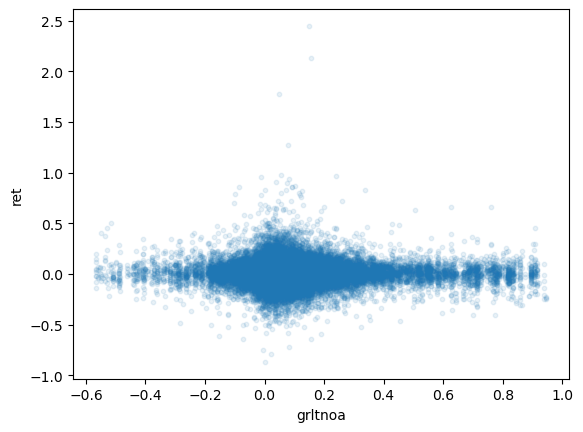

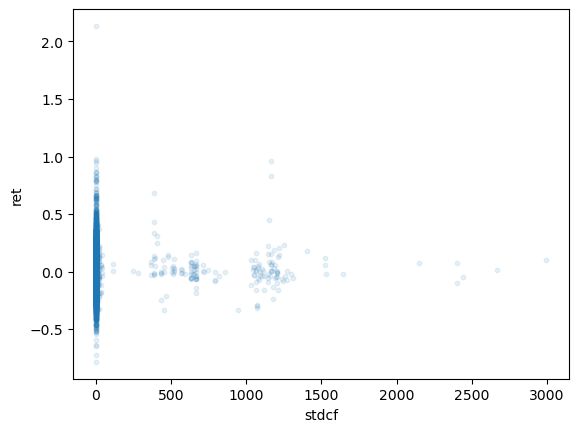

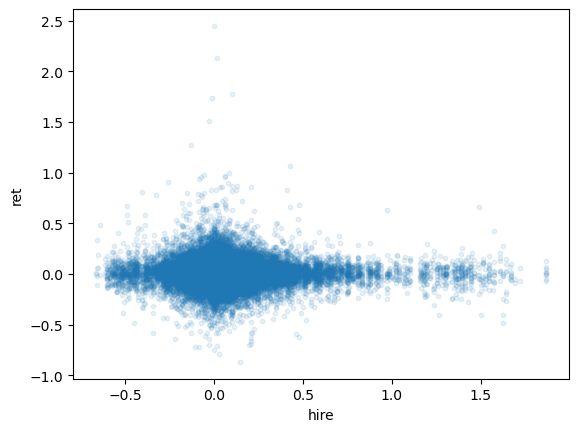

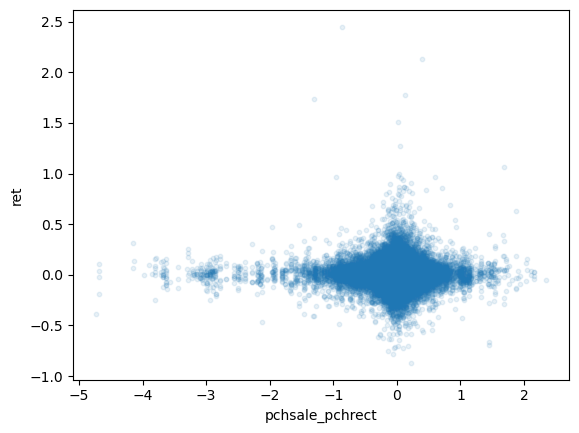

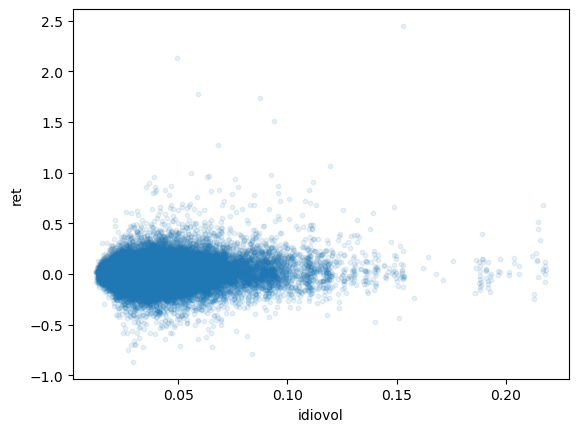

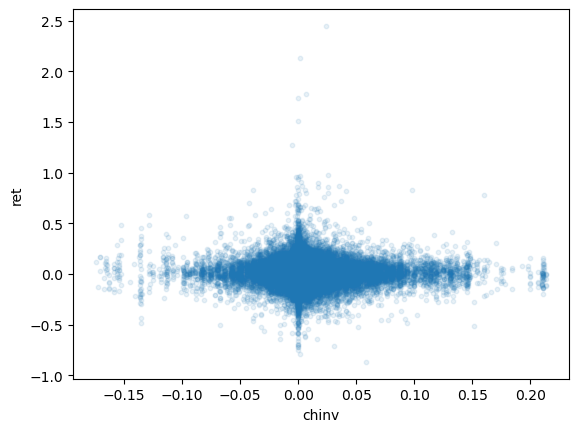

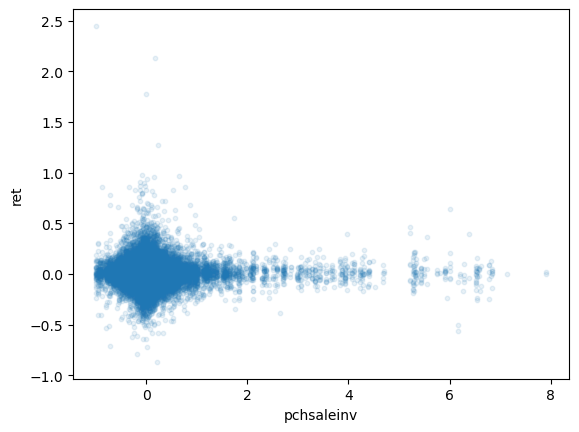

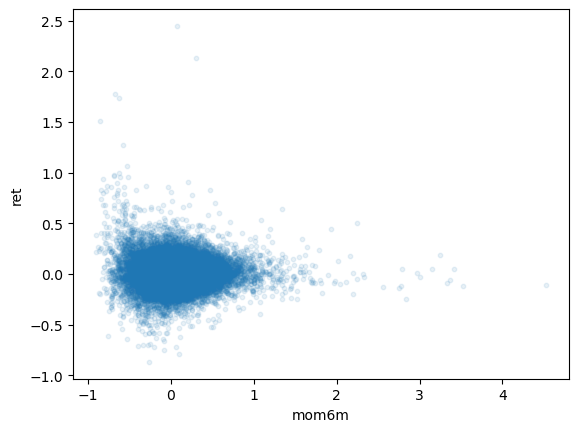

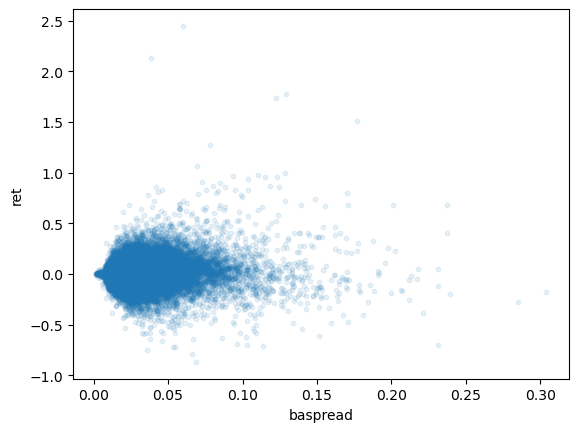

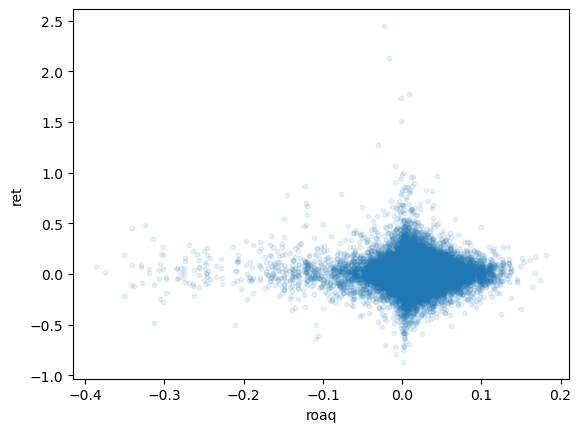

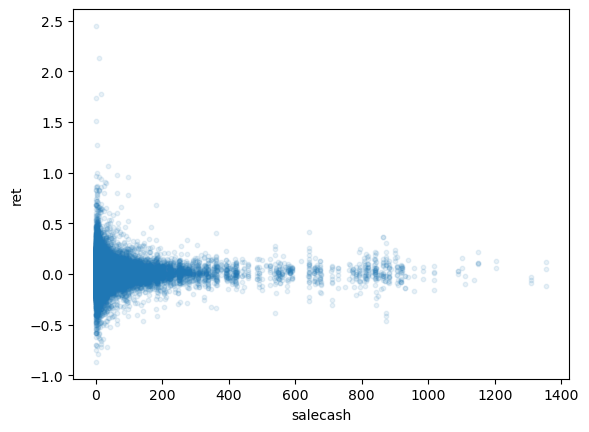

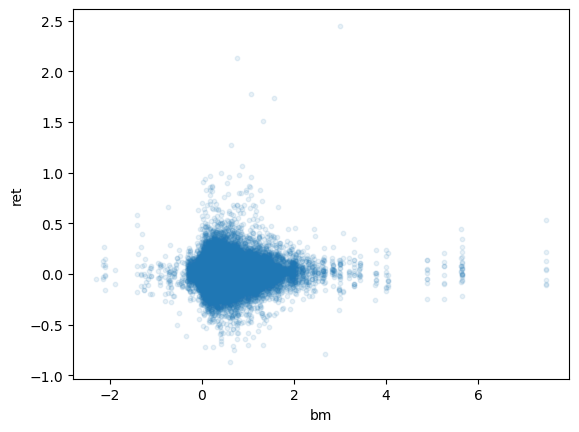

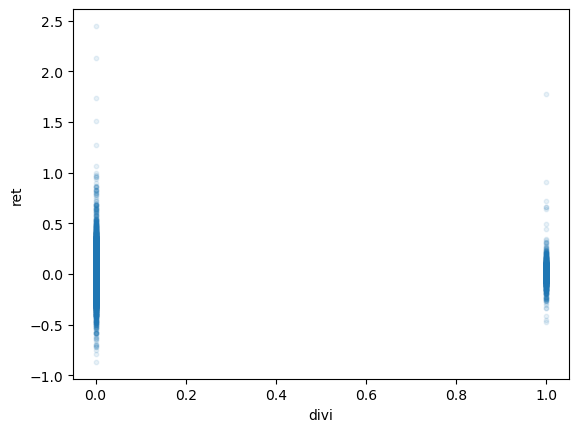

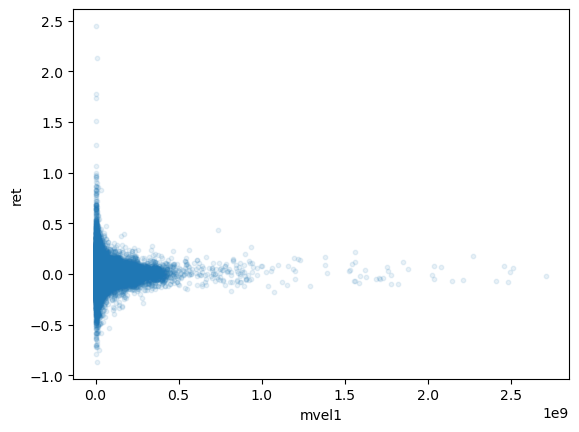

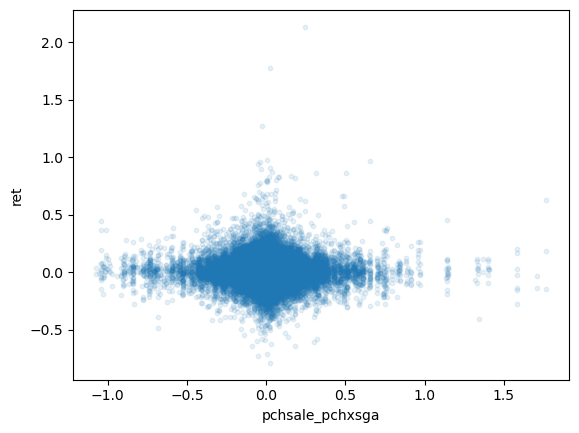

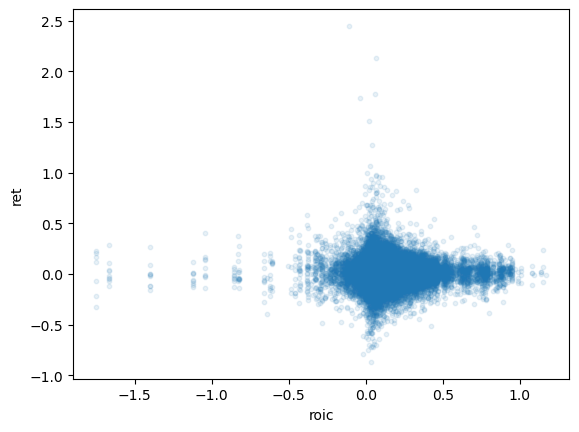

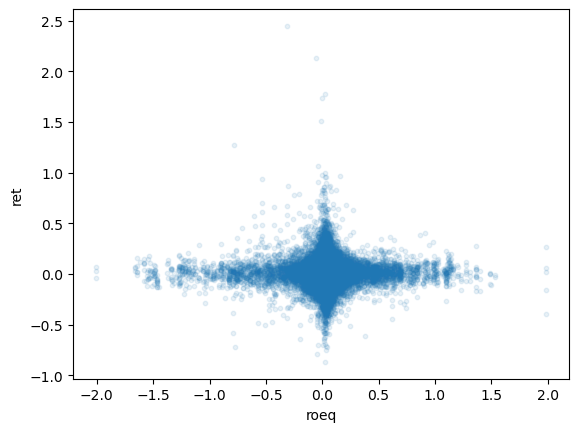

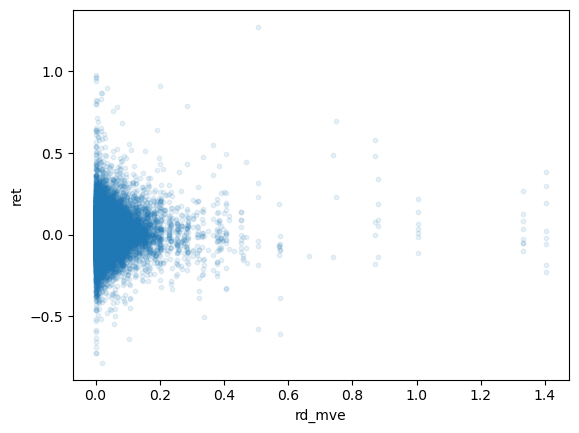

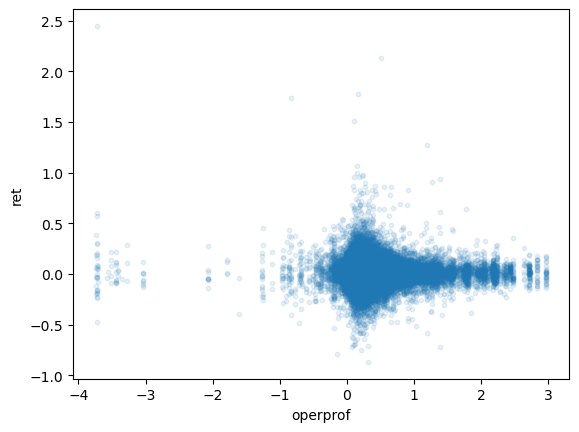

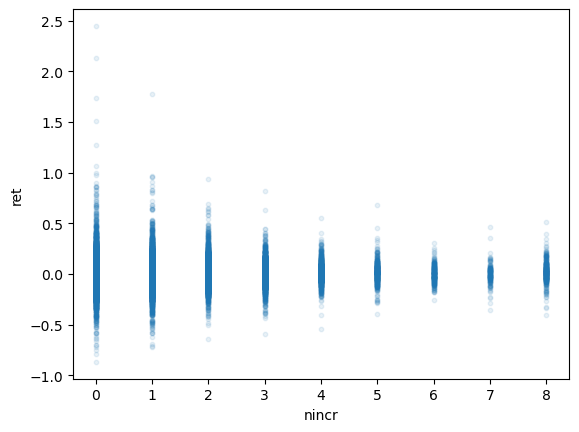

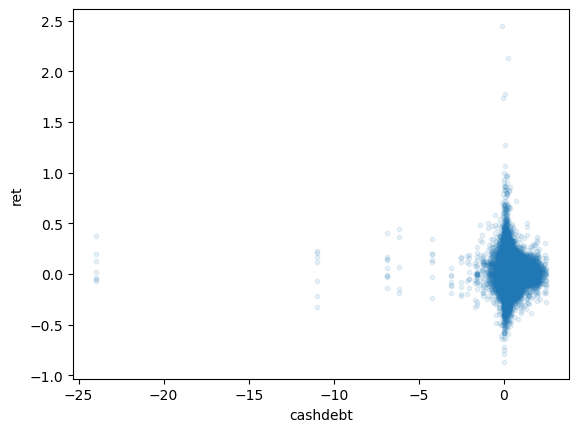

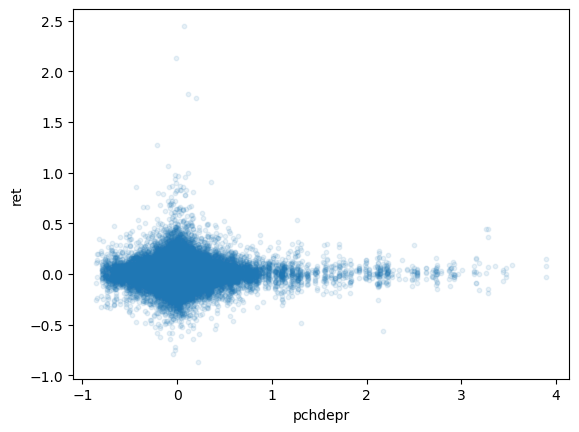

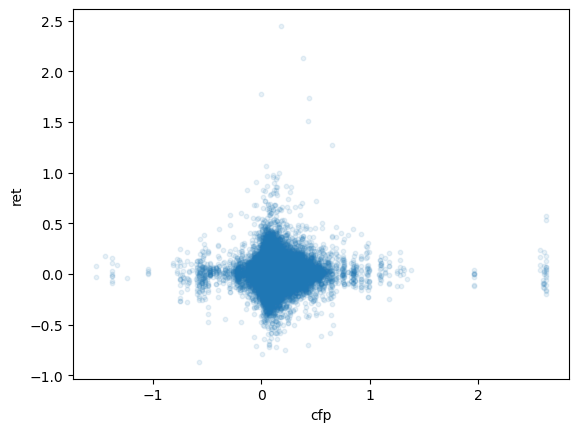

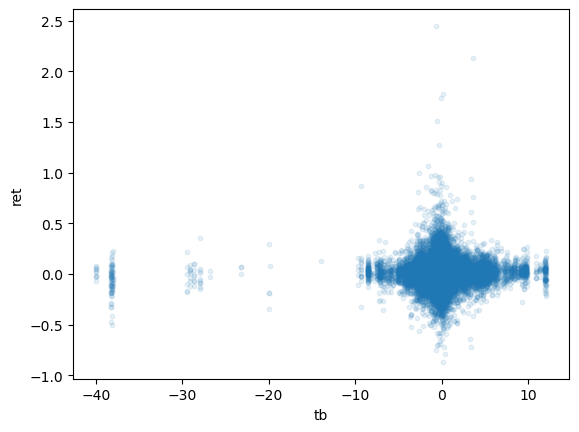

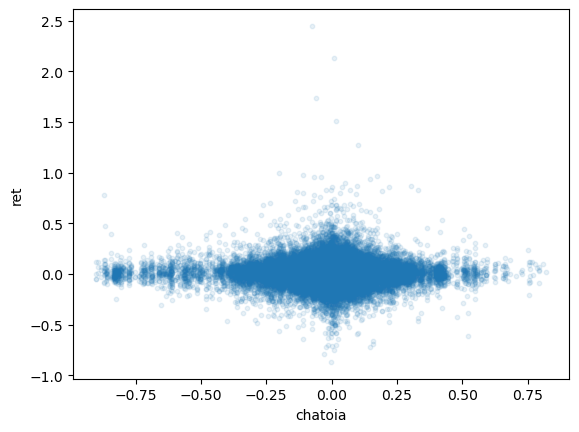

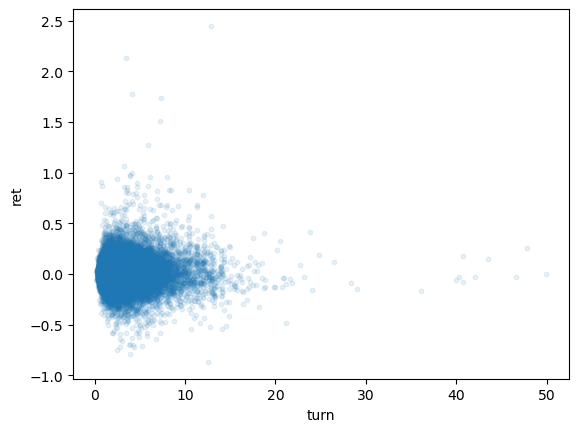

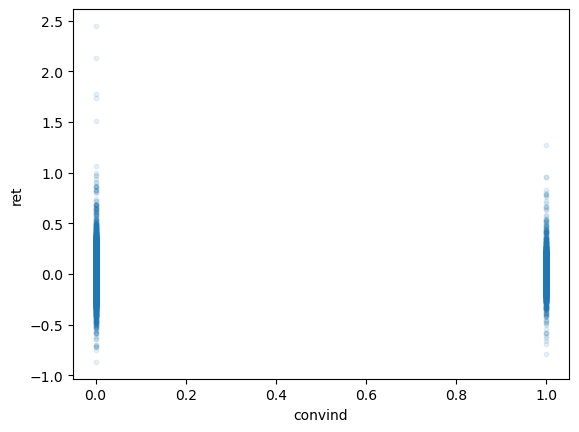

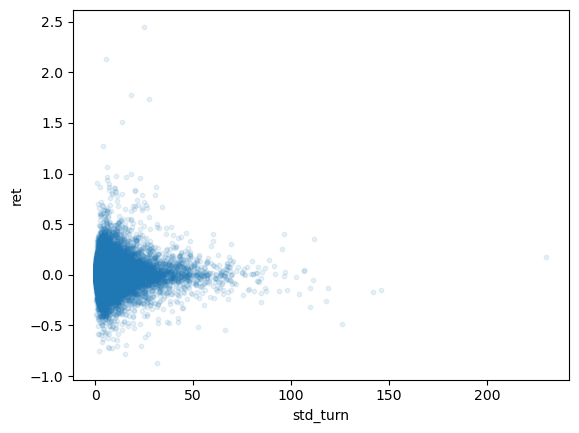

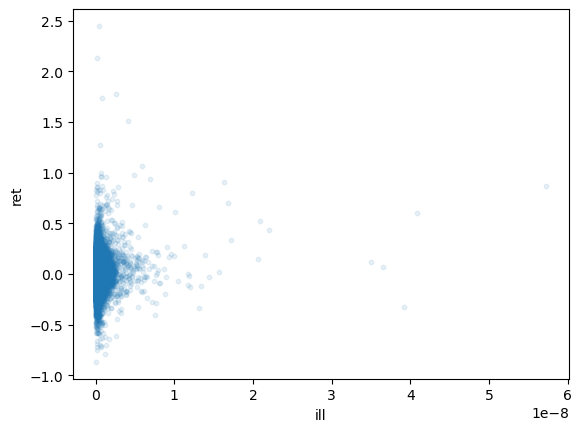

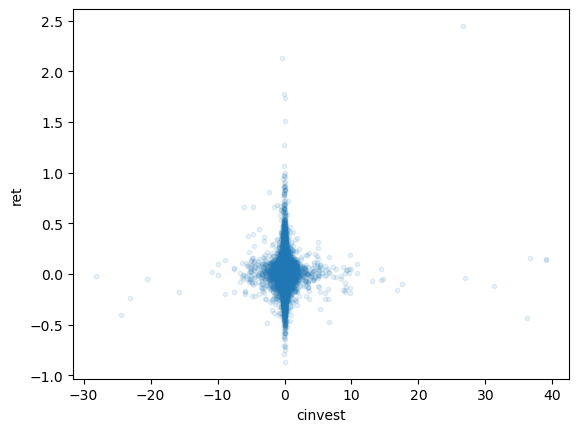

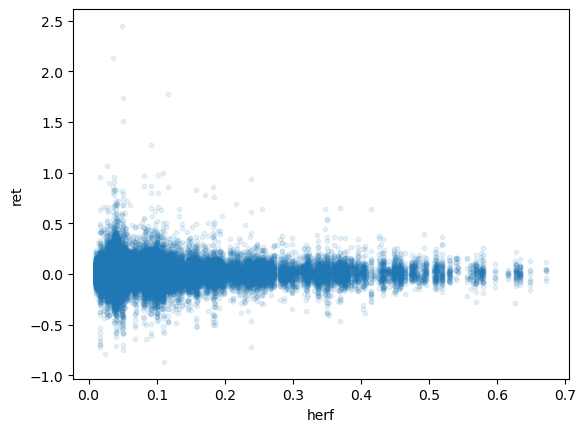

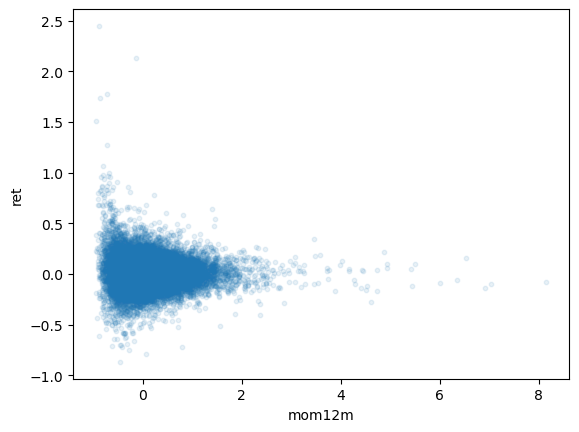

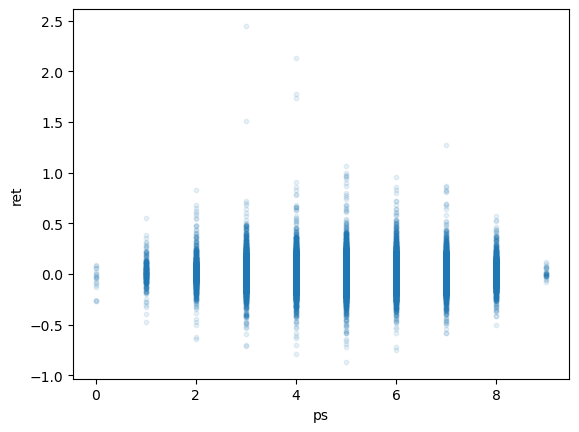

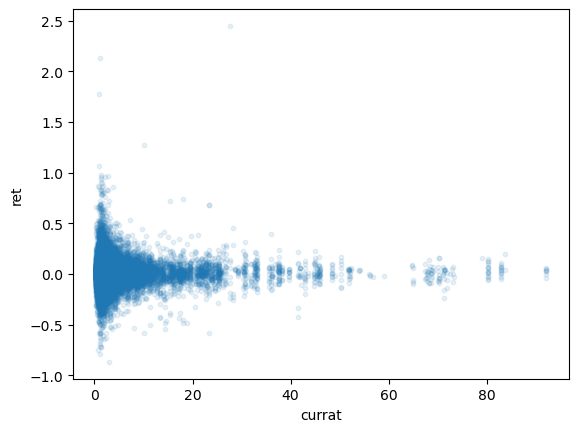

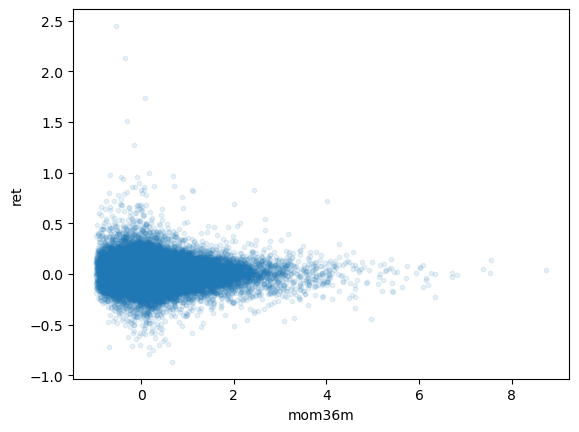

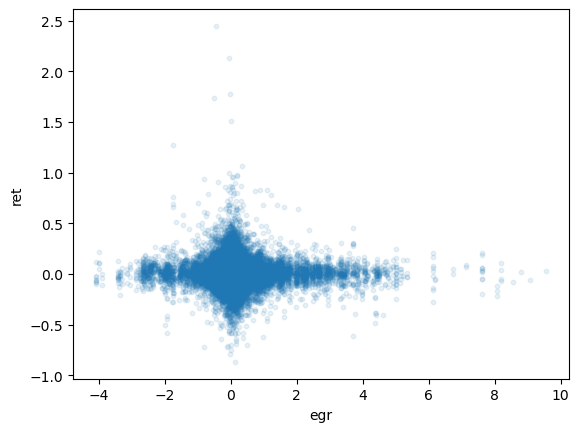

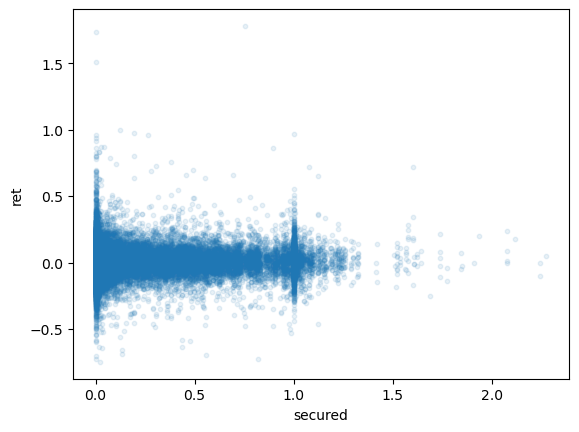

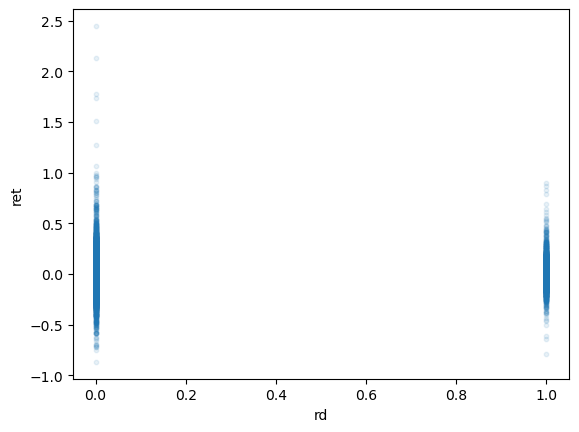

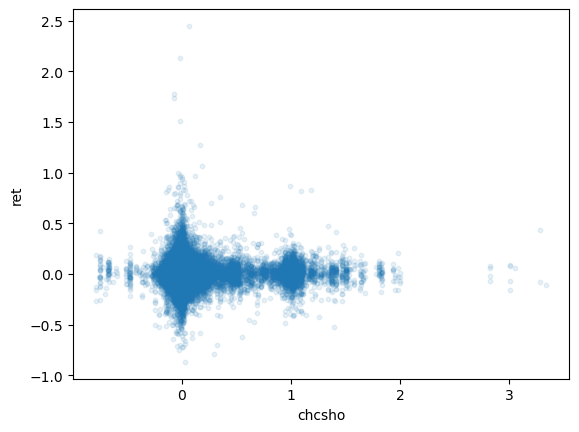

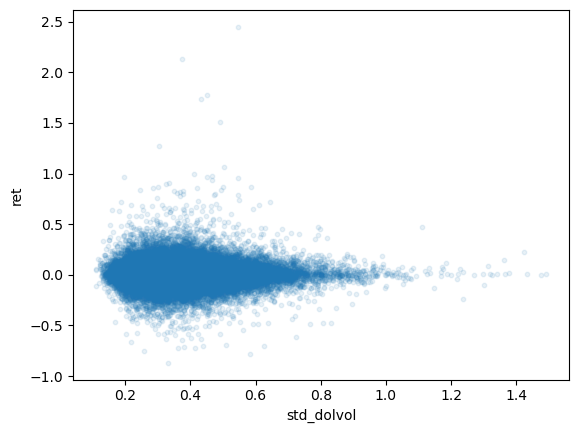

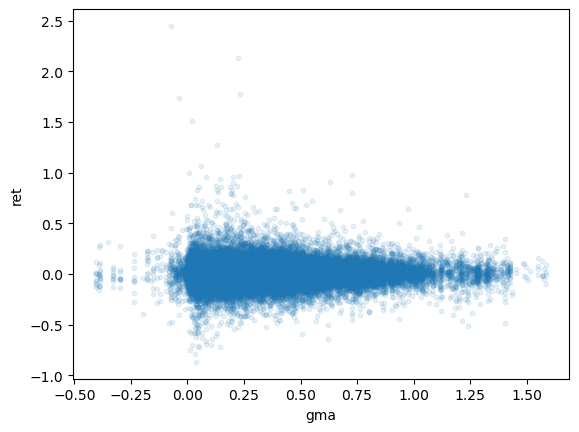

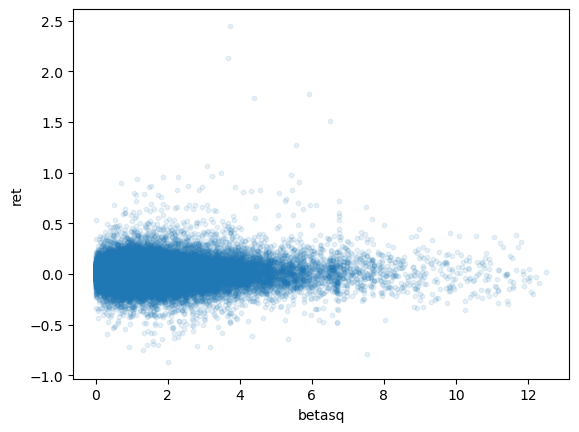

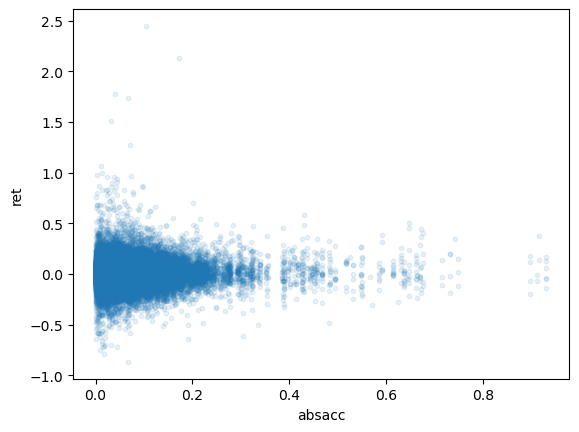

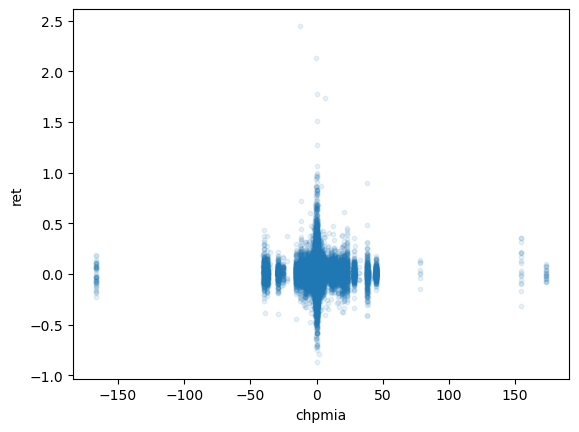

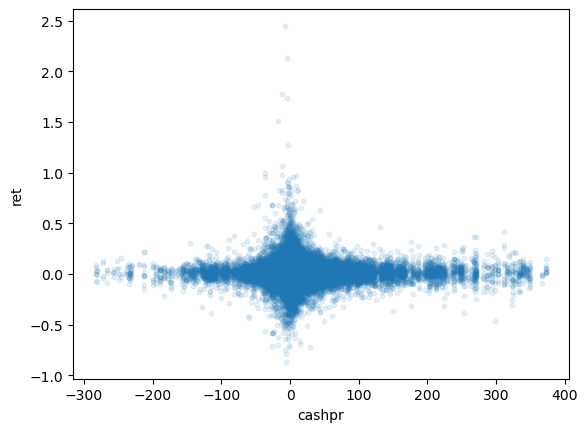

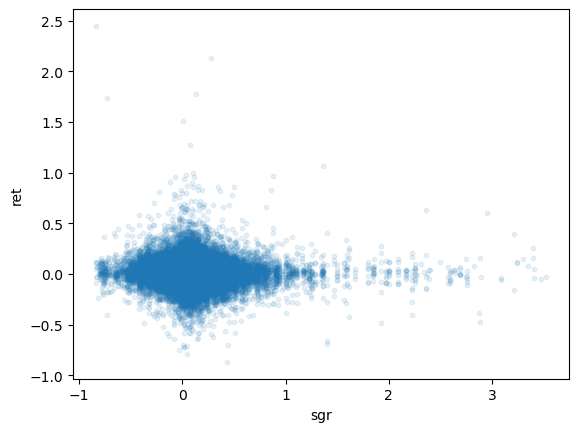

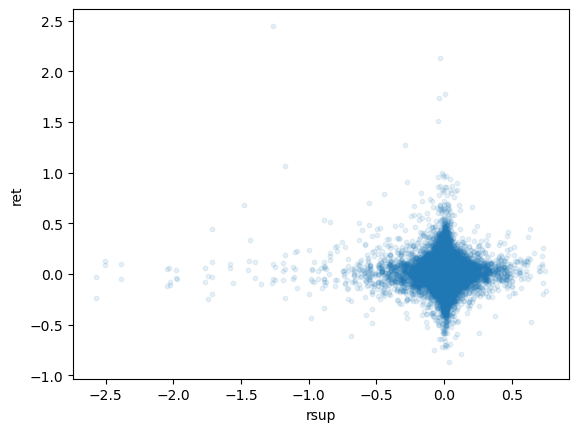

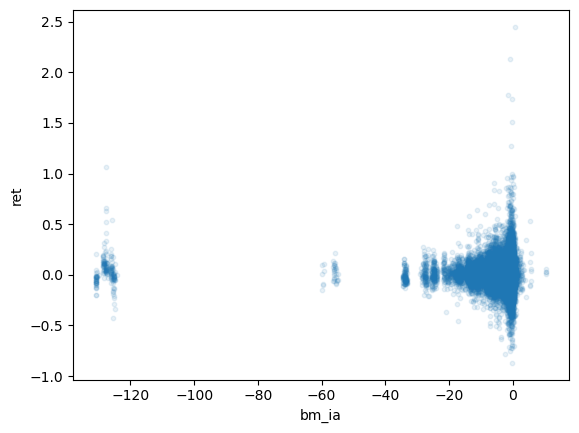

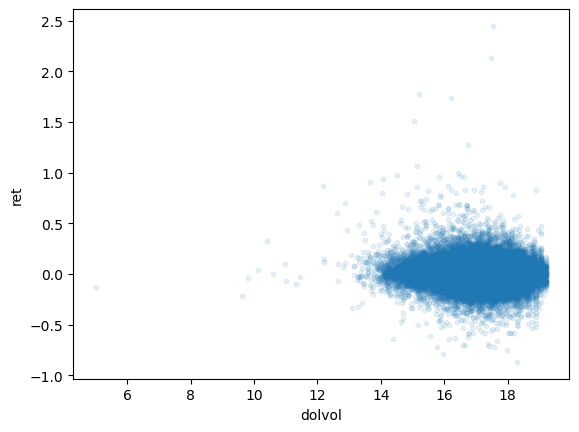

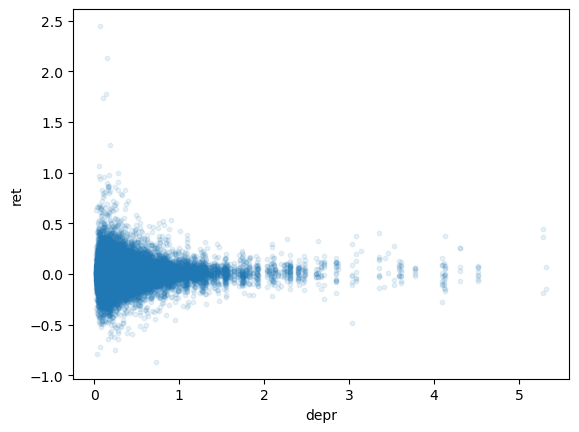

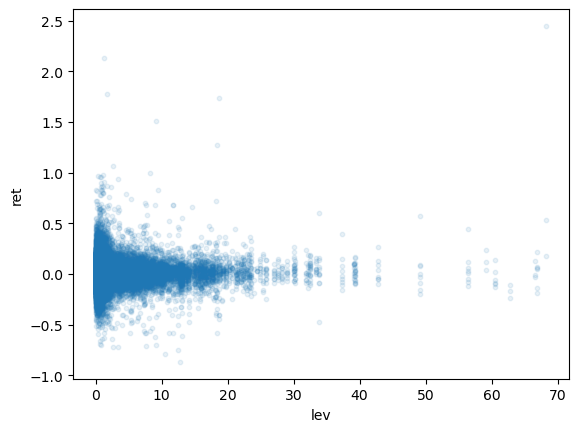

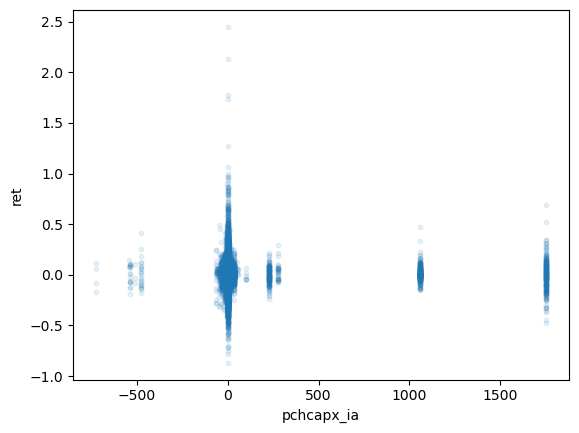

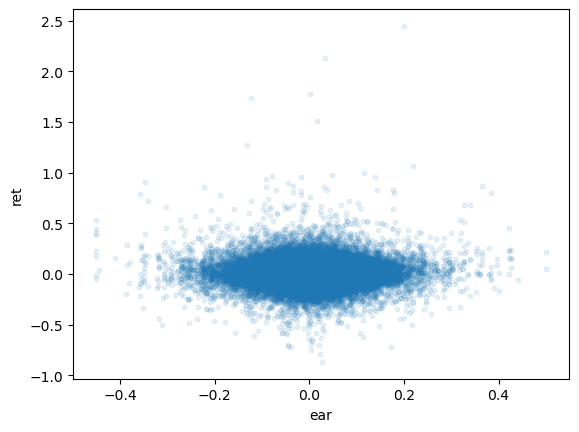

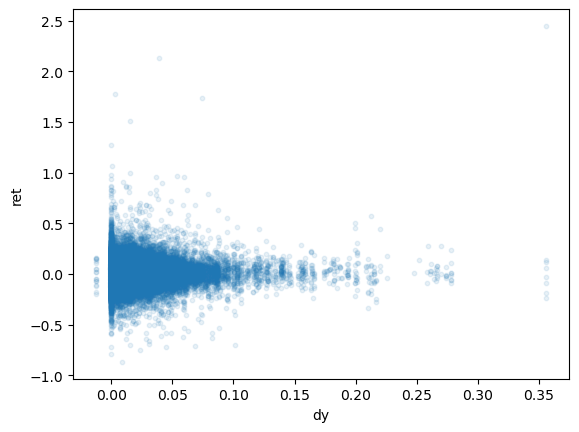

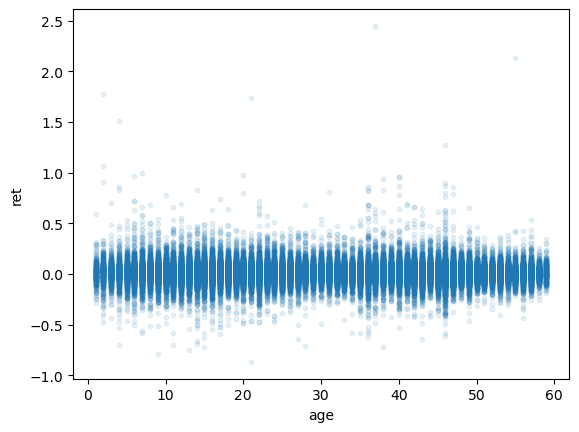

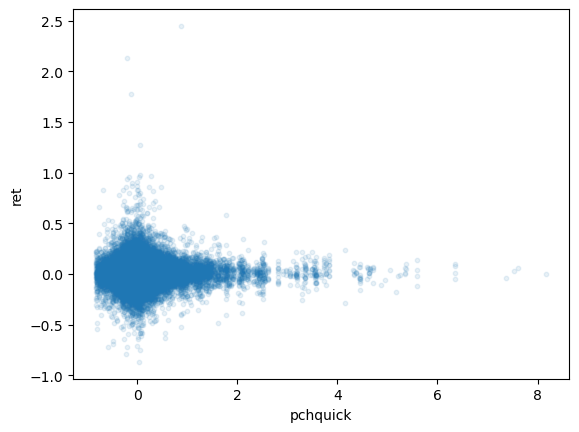

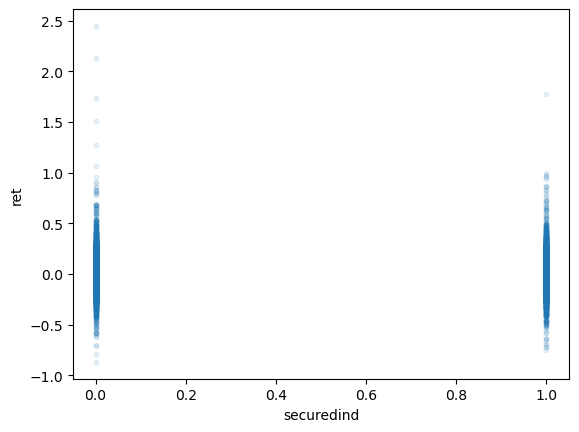

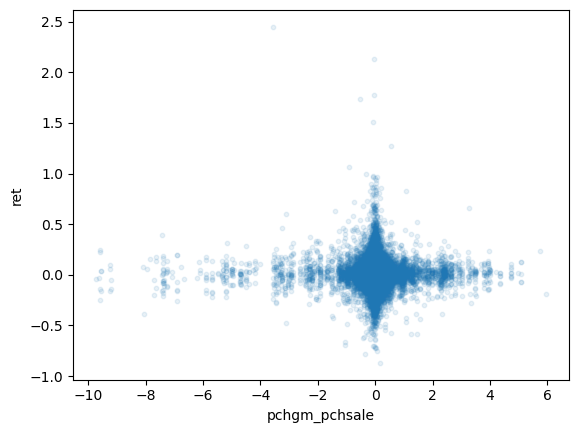

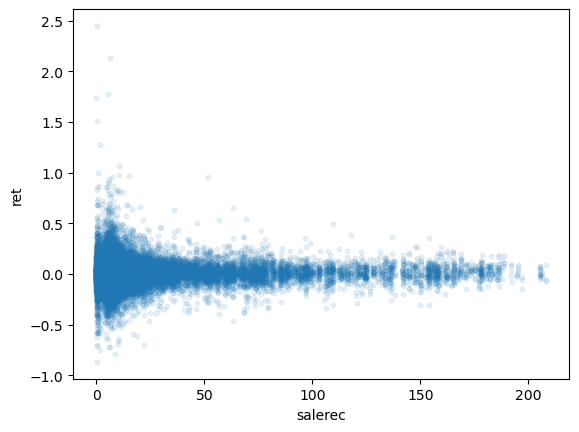

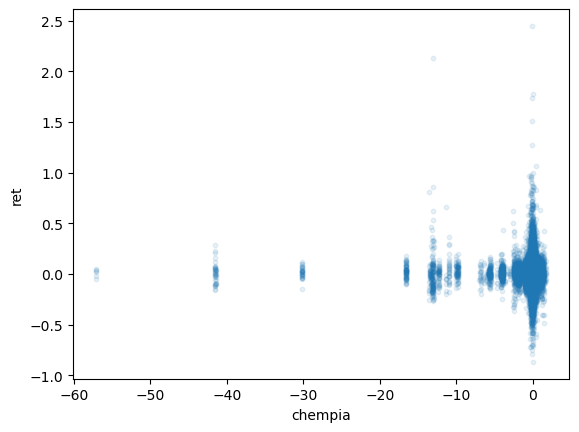

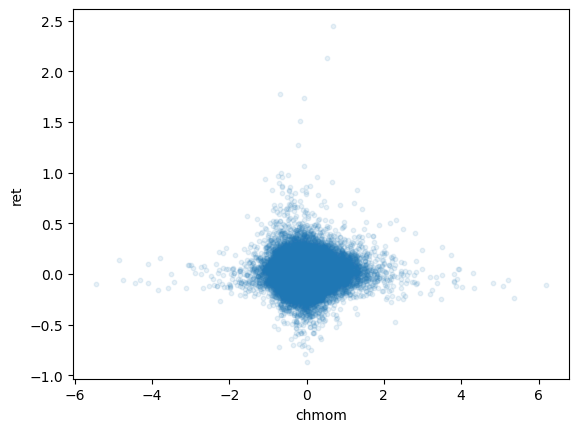

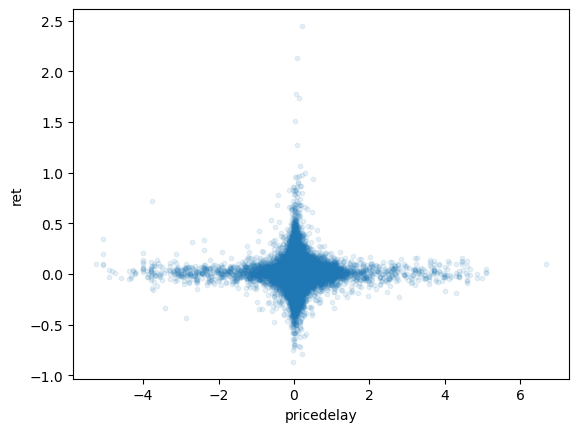

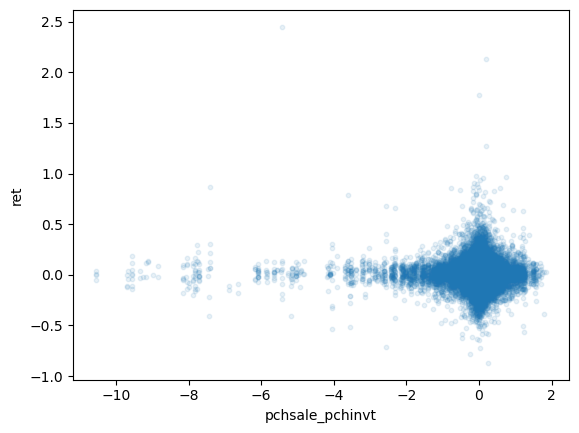

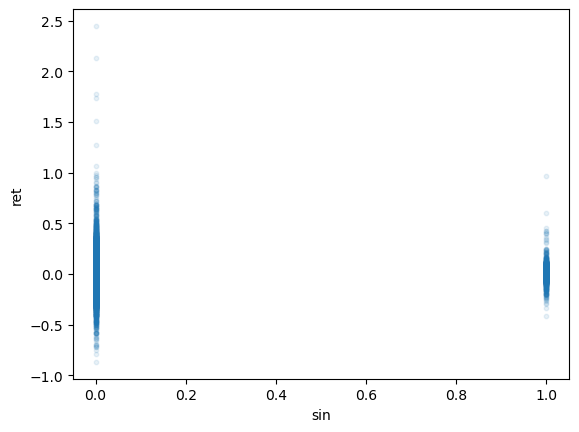

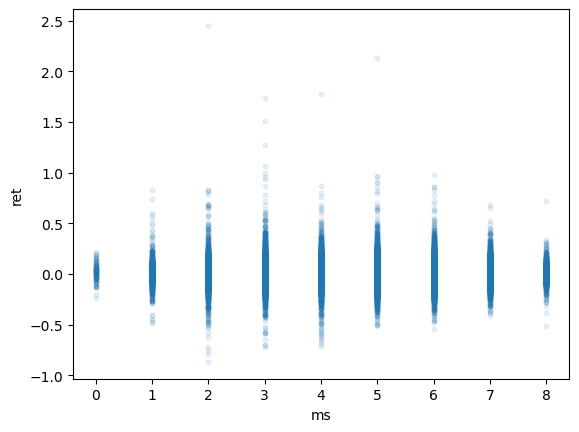

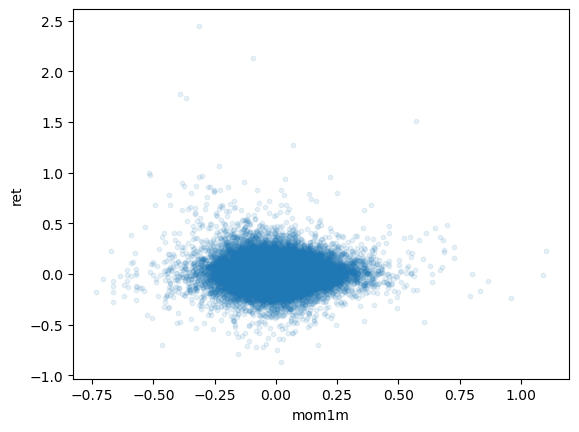

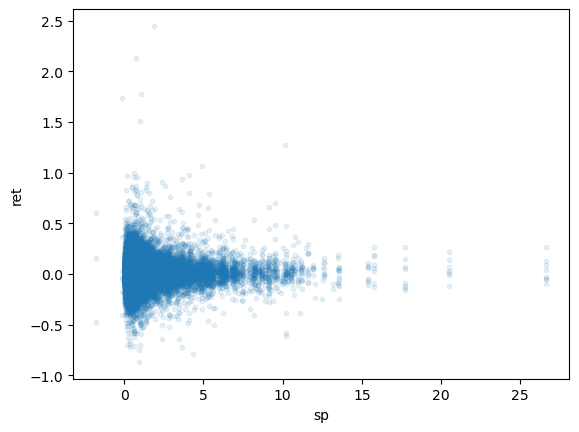

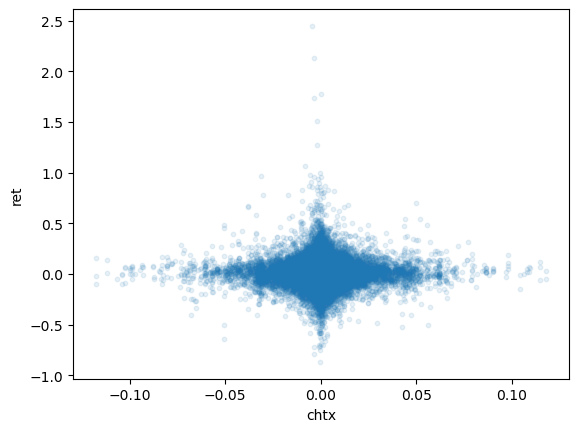

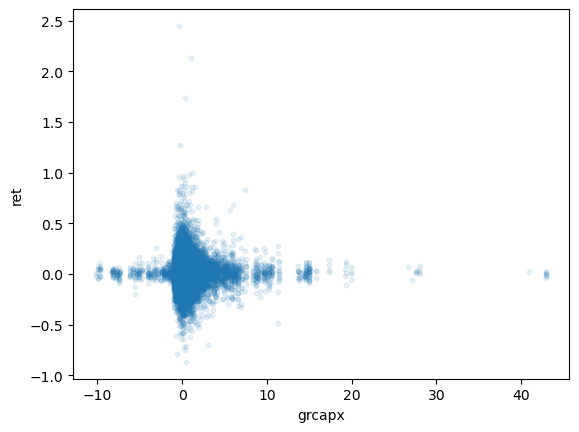

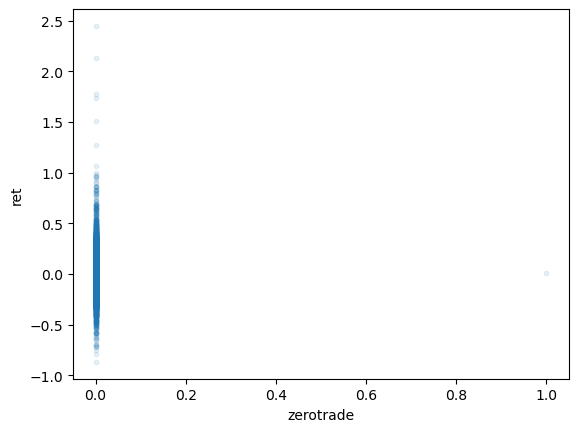

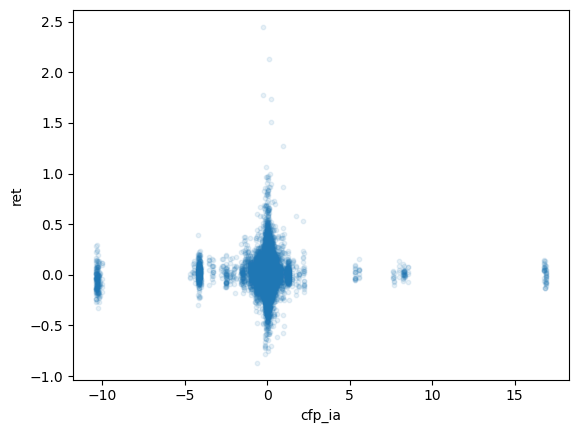

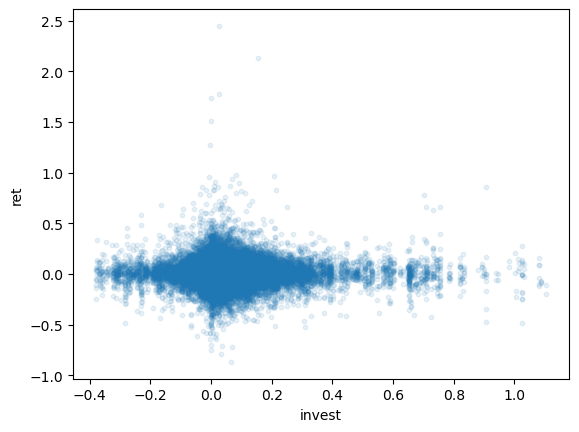

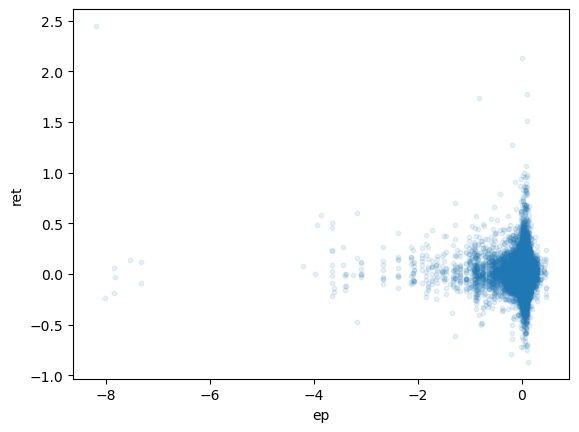

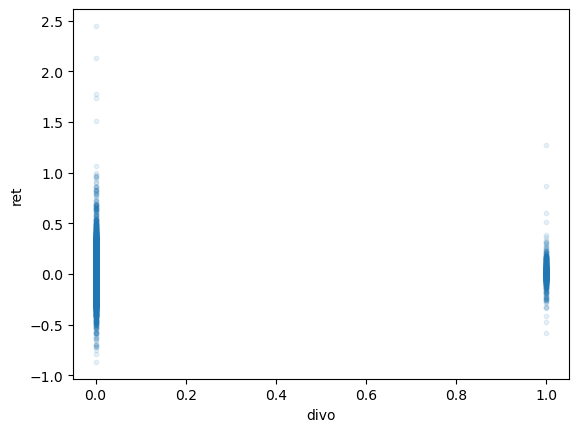

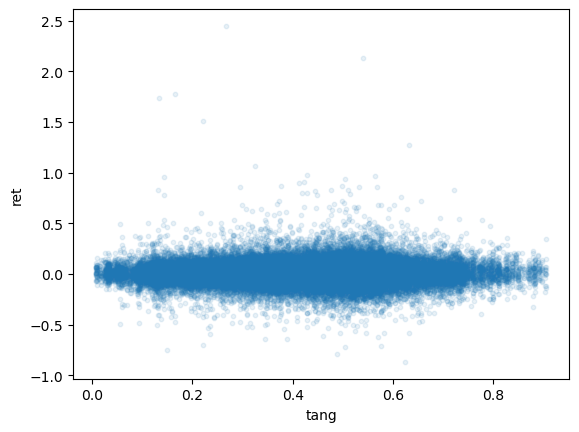

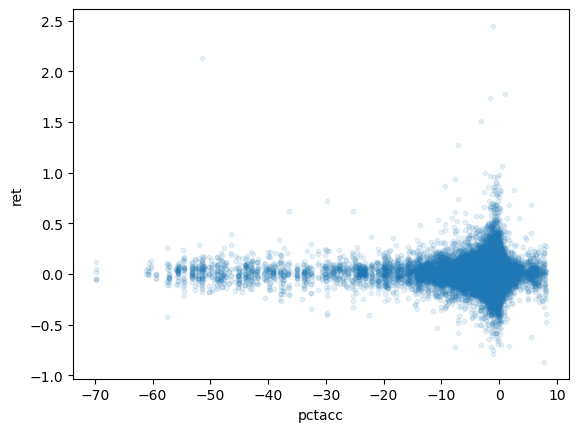

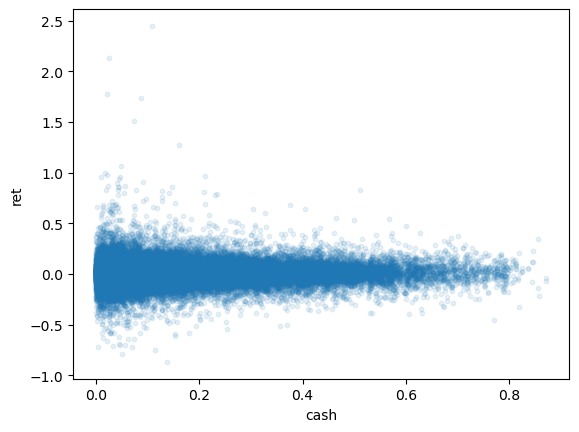

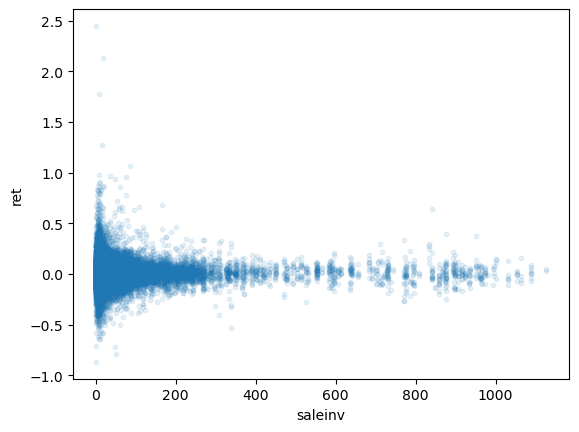

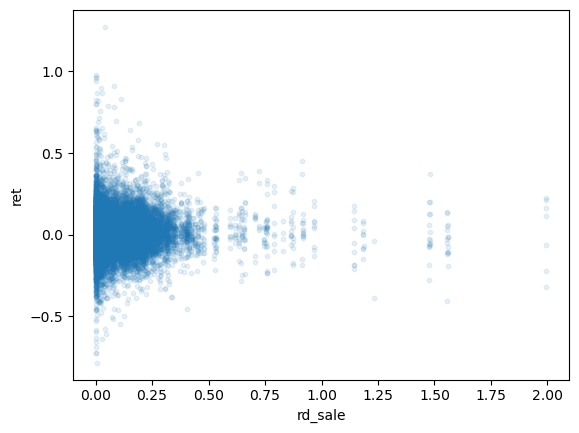

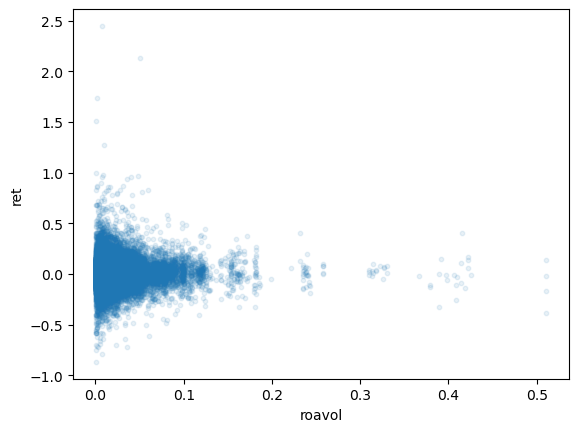

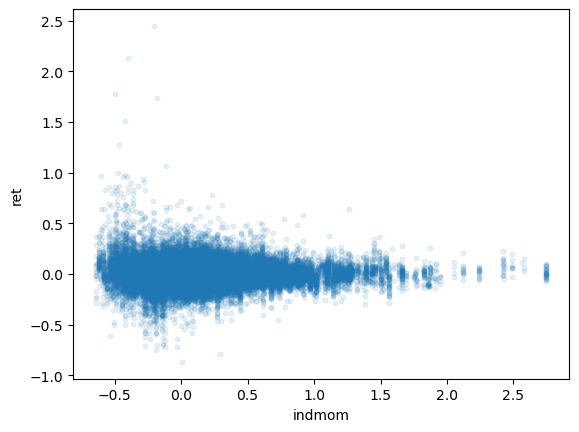

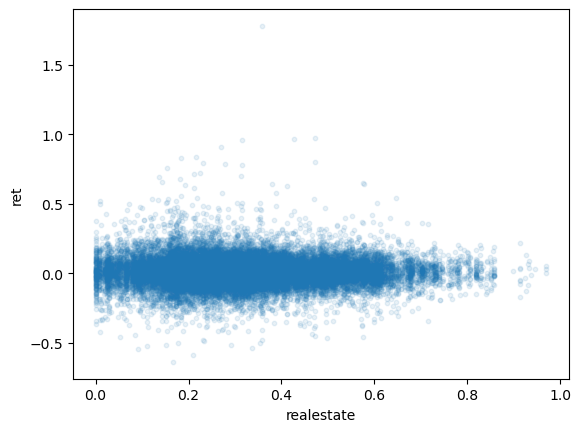

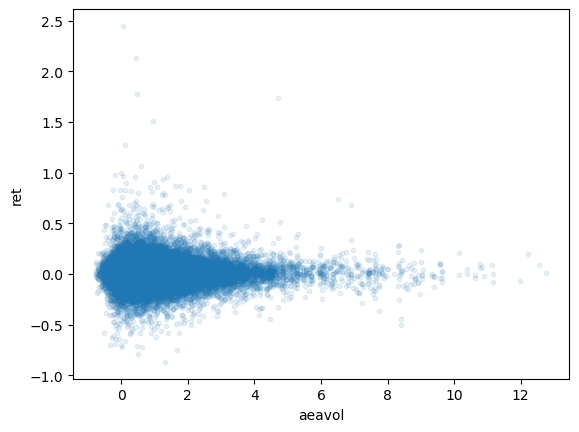

In [210]:
for feature in new_char:
    df.plot.scatter(feature, 'ret', alpha=0.1, s=10)
    plt.show()

In [227]:
df[df['zerotrade']>0.1]

permno         mvel1   betasq     chmom     dolvol  idiovol  \
date                                                                      
2003-01-31   76656  6.826789e+06  1.88493  0.459587  16.913028  0.06635   

             indmom     mom1m     mom6m    mom12m  ...   ms  baspread  \
date                                               ...                  
2003-01-31 -0.25943  0.029947 -0.000758 -0.430852  ...  4.0  0.042804   

                     ill  std_dolvol   std_turn  zerotrade  sic2       ret  \
date                                                                         
2003-01-31  1.971203e-10    0.690064  23.197378        1.0  28.0  0.007385   

            weighted_ret  ret_lag5  
date                                
2003-01-31  50415.869303       NaN  

[1 rows x 88 columns]

In [228]:
# discard features
df = df.drop(columns='zerotrade')

In [213]:
# discrete variable
df['nincr'].value_counts() #Number of earnings increases

nincr
0.0    36277
1.0    23915
2.0    11468
3.0     4974
4.0     1315
5.0      554
8.0      426
6.0      302
7.0      170
Name: count, dtype: int64

## Splitting & Preprocessing

In [377]:
new_char = list(new_char.difference({'zerotrade'}))

In [311]:
train_dates = df.index.get_level_values('date').unique()

In [302]:
def process(group):
    return group.iloc[0, :]
     
newdf = df.groupby('date').apply(process)
newdf

permno         mvel1    betasq     chmom     dolvol   idiovol  \
date                                                                         
2003-01-31  10078.0  9.936164e+06  3.608050  0.213441  17.586136  0.076955   
2003-02-28  10078.0  9.872265e+06  3.667252  0.423953  17.314572  0.077289   
2003-03-31  10078.0  1.099048e+07  3.651351  0.498642  17.377240  0.077014   
2003-04-30  10078.0  1.052864e+07  3.715901  0.965037  17.198271  0.077109   
2003-06-30  10078.0  1.404896e+07  3.866900  0.390963  17.379784  0.077644   
...             ...           ...       ...       ...        ...       ...   
2021-06-30  10104.0  2.270495e+08  0.167192  0.292654  19.084002  0.027565   
2021-08-31  10104.0  2.432949e+08  0.178724  0.354586  19.188071  0.028507   
2021-09-30  10104.0  2.488510e+08  0.169872  0.255853  18.968600  0.029099   
2021-11-30  10104.0  2.622698e+08  0.159401 -0.087077  19.042739  0.028938   
2021-12-31  10104.0  2.480547e+08  0.153599 -0.214882  18.954315  0.028826   

              indmom     mom1m     mom6m    mom12m  ...     stdcf   ms  \
date                                                ...                  
2003-01-31 -0.133079 -0.275227 -0.143513 -0.651138  ...  0.121279  5.0   
2003-02-28 -0.228906 -0.006431 -0.206633 -0.710967  ...  0.121279  5.0   
2003-03-31 -0.198674  0.113269 -0.162602 -0.636898  ...  0.121279  5.0   
2003-04-30 -0.281494 -0.052326  0.328185 -0.609977  ...  0.122729  5.0   
2003-06-30 -0.145636  0.314199 -0.228618 -0.519594  ...  0.122729  5.0   
...              ...       ...       ...       ...  ...       ...  ...   
2021-06-30  1.097983  0.038923  0.323844  0.433351  ...  0.259138  5.0   
2021-08-31  0.832380  0.123587  0.293540  0.421367  ...  0.259138  5.0   
2021-09-30  0.588704  0.022837  0.361483  0.547628  ...  0.268859  5.0   
2021-11-30  0.684916  0.104786  0.153846  0.571341  ...  0.268859  5.0   
2021-12-31  0.406290 -0.054201  0.226994  0.687573  ...  0.268869  6.0   

            baspread           ill  std_dolvol  std_turn  sic2       ret  \
date                                                                       
2003-01-31  0.061680  1.807258e-10    0.283794  4.260413  35.0  0.113269   
2003-02-28  0.067185  1.983853e-10    0.257800  4.958259  35.0 -0.052326   
2003-03-31  0.048522  1.640835e-10    0.155110  1.796167  35.0  0.015337   
2003-04-30  0.048646  1.616207e-10    0.250274  3.854210  35.0  0.314199   
2003-06-30  0.062129  1.046161e-10    0.373200  8.706452  35.0 -0.191398   
...              ...           ...         ...       ...   ...       ...   
2021-06-30  0.016420  9.361472e-12    0.320314  1.175556  73.0  0.123587   
2021-08-31  0.023968  1.187178e-11    0.317484  1.334534  73.0 -0.022439   
2021-09-30  0.013392  7.814219e-12    0.185576  0.472331  73.0  0.104786   
2021-11-30  0.018713  1.177983e-11    0.281391  0.946735  73.0 -0.038902   
2021-12-31  0.019303  1.291392e-11    0.369115  1.468823  73.0 -0.065703   

            weighted_ret  ret_lag5  
date                                
2003-01-31  1.125456e+06       NaN  
2003-02-28 -5.165722e+05       NaN  
2003-03-31  1.685655e+05       NaN  
2003-04-30  3.308093e+06       NaN  
2003-06-30 -2.688940e+06       NaN  
...                  ...       ...  
2021-06-30  2.806035e+07 -0.056114  
2021-08-31 -5.459327e+06  0.120755  
2021-09-30  2.607610e+07 -0.062143  
2021-11-30 -1.020291e+07  0.084652  
2021-12-31 -1.629804e+07  0.038923  

[160 rows x 87 columns]

In [322]:
def rolling_window_split(df):
    # 4-1-1 train/val/test split, 5 folds
    fold_size = np.floor(len(df) / 10).astype(int)
    for i in range(5):
        if i != 4:
            yield (list(range(i*fold_size, (i+4)*fold_size)),
                   list(range((i+4)*fold_size, (i+5)*fold_size)),
                   list(range((i+5)*fold_size, (i+6)*fold_size)))
        if i == 4:
            yield (list(range(i*fold_size, (i+4)*fold_size)),
                   list(range((i+4)*fold_size, (i+5)*fold_size)),
                   list(range((i+5)*fold_size, len(df))))

In [323]:
for i, (train_index, val_index, test_index) in enumerate(rolling_window_split(newdf)):
    print('train {} length:'.format(i+1), len(train_index))
    print('train {}: '.format(i+1), [train_dates[train_index[0]].strftime('%Y-%m-%d'), 
                                     train_dates[train_index[-1]].strftime('%Y-%m-%d')])
    print('val {} length:'.format(i+1),len(val_index))
    print('val {}:'.format(i+1), [train_dates[val_index[0]].strftime('%Y-%m-%d'), 
                                   train_dates[val_index[-1]].strftime('%Y-%m-%d')])
    print('test {} length:'.format(i+1),len(test_index))
    print('test {}:'.format(i+1), [train_dates[test_index[0]].strftime('%Y-%m-%d'), 
                                   train_dates[test_index[-1]].strftime('%Y-%m-%d')])

train 1 length: 64
train 1:  ['2003-01-31', '2010-08-31']
val 1 length: 16
val 1: ['2010-09-30', '2012-05-31']
test 1 length: 16
test 1: ['2012-07-31', '2014-03-31']
train 2 length: 64
train 2:  ['2005-01-31', '2012-05-31']
val 2 length: 16
val 2: ['2012-07-31', '2014-03-31']
test 2 length: 16
test 2: ['2014-04-30', '2016-03-31']
train 3 length: 64
train 3:  ['2006-10-31', '2014-03-31']
val 3 length: 16
val 3: ['2014-04-30', '2016-03-31']
test 3 length: 16
test 3: ['2016-05-31', '2018-01-31']
train 4 length: 64
train 4:  ['2008-07-31', '2016-03-31']
val 4 length: 16
val 4: ['2016-05-31', '2018-01-31']
test 4 length: 16
test 4: ['2018-02-28', '2019-12-31']
train 5 length: 64
train 5:  ['2010-09-30', '2018-01-31']
val 5 length: 16
val 5: ['2018-02-28', '2019-12-31']
test 5 length: 16
test 5: ['2020-01-31', '2021-12-31']


In [439]:
X_train1 = df.loc['2003-01-31':'2010-08-31', df.columns!='ret']
X_val1 = df.loc['2010-09-30':'2012-05-31', df.columns!='ret']
X_test1 = df.loc['2012-07-31': '2014-03-31', df.columns!='ret']
y_train1 = df.loc['2003-01-31':'2010-08-31', 'ret']
y_val1 = df.loc['2010-09-30':'2012-05-31', 'ret']
y_test1 = df.loc['2012-07-31': '2014-03-31', 'ret']

Standard Scalar

In [433]:
from sklearn.preprocessing import StandardScaler

def fit_transform(train):
    # Group by 'month' and apply rank transformation to 'characteristic' columns
    ranked_df = train.groupby(train.index).apply(lambda group: group.loc[:, new_char].rank())
    # Apply Standard Scaling to ranked data
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(ranked_df)
    scaled_df = pd.DataFrame(train, columns=train.columns)
    scaled_df.index = train.index
    return scaled_df

In [441]:
def transform(test):
    ranked_df = test.groupby(test.index).apply(lambda group: group.loc[:, new_char].rank())
#     # Apply Standard Scaling to ranked data
#     scaler = StandardScaler()
    scaled_df = scaler.transform(ranked_df)
    scaled_df = pd.DataFrame(test, columns=test.columns)
    scaled_df.index = test.index
    return scaled_df

In [442]:
X_train1_sc, X_val1_sc, X_test1_sc= rank_norm_fit(X_train1), transform(X_val1), transform(X_test1)
print(X_train1_sc)
print(X_val1_sc)
print(X_test1_sc)

            permno         mvel1    betasq     chmom     dolvol   idiovol  \
date                                                                        
2003-01-31   10078  9.936164e+06  3.608050  0.213441  17.586136  0.076955   
2003-01-31   10104  5.690643e+07  2.031124  0.454709  17.586136  0.081222   
2003-01-31   10107  2.766308e+08  1.254327  0.119495  17.586136  0.049207   
2003-01-31   10108  6.671226e+06  0.480190 -0.025585  15.661298  0.061650   
2003-01-31   10137  9.501862e+05  0.305354 -0.427092  14.657669  0.084573   
...            ...           ...       ...       ...        ...       ...   
2010-08-31   92655  3.461191e+07  1.050348 -0.248345  18.018145  0.065211   
2010-08-31   92709  5.539939e+06  0.910289 -0.326457  15.773985  0.036207   
2010-08-31   92890  1.086968e+07  0.102697 -0.068198  16.921247  0.035108   
2010-08-31   92988  4.683945e+06       NaN       NaN  15.970431       NaN   
2010-08-31   93422  6.028353e+06       NaN       NaN        NaN       NaN   

One-hot Encoder

In [446]:
from sklearn.preprocessing import OneHotEncoder

def OH(df):
    # Apply one-hot encoder to Industry Name
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[['sic2']]))

    # One-hot encoding removed index; put it back
    OH_cols.index = df.index
    return OH_cols

In [448]:
X_train1 = pd.concat([X_train1, OH(X_train1)], axis=1).drop(columns='sic2')
X_val1 = pd.concat([X_val1, OH(X_val1)], axis=1).drop(columns='sic2')
X_test1 = pd.concat([X_test1, OH(X_test1)], axis=1).drop(columns='sic2')
X_train1

/Users/luyifan/opt/anaconda3/envs/data1030/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


permno         mvel1    betasq     chmom     dolvol   idiovol  \
date                                                                        
2003-01-31   10078  9.936164e+06  3.608050  0.213441  17.586136  0.076955   
2003-01-31   10104  5.690643e+07  2.031124  0.454709  17.586136  0.081222   
2003-01-31   10107  2.766308e+08  1.254327  0.119495  17.586136  0.049207   
2003-01-31   10108  6.671226e+06  0.480190 -0.025585  15.661298  0.061650   
2003-01-31   10137  9.501862e+05  0.305354 -0.427092  14.657669  0.084573   
...            ...           ...       ...       ...        ...       ...   
2010-08-31   92655  3.461191e+07  1.050348 -0.248345  18.018145  0.065211   
2010-08-31   92709  5.539939e+06  0.910289 -0.326457  15.773985  0.036207   
2010-08-31   92890  1.086968e+07  0.102697 -0.068198  16.921247  0.035108   
2010-08-31   92988  4.683945e+06       NaN       NaN  15.970431       NaN   
2010-08-31   93422  6.028353e+06       NaN       NaN        NaN       NaN   

              indmom     mom1m     mom6m    mom12m  ...   50   51   52   53  \
date                                                ...                       
2003-01-31 -0.133079 -0.275227 -0.143513 -0.651138  ...  0.0  0.0  0.0  0.0   
2003-01-31 -0.206804 -0.111111  0.282999 -0.120203  ...  0.0  0.0  0.0  1.0   
2003-01-31 -0.206804 -0.103675  0.054479 -0.129358  ...  0.0  0.0  0.0  1.0   
2003-01-31 -0.206804  0.008130 -0.117447 -0.192188  ...  0.0  0.0  0.0  1.0   
2003-01-31 -0.126755  0.097242 -0.723644 -0.798171  ...  0.0  0.0  0.0  0.0   
...              ...       ...       ...       ...  ...  ...  ...  ...  ...   
2010-08-31  0.134945  0.072183 -0.134751  0.017578  ...  0.0  0.0  0.0  0.0   
2010-08-31  0.500280  0.056767 -0.051908  0.259417  ...  0.0  0.0  0.0  0.0   
2010-08-31  0.186381  0.060255  0.117902  0.401245  ...  0.0  0.0  0.0  0.0   
2010-08-31  0.160946 -0.071806 -0.118447       NaN  ...  0.0  0.0  0.0  0.0   
2010-08-31  0.160946       NaN       NaN       NaN  ...  0.0  0.0  0.0  0.0   

             54   55   56   57   58   59  
date                                      
2003-01-31  0.0  0.0  0.0  0.0  0.0  0.0  
2003-01-31  0.0  0.0  0.0  0.0  0.0  0.0  
2003-01-31  0.0  0.0  0.0  0.0  0.0  0.0  
2003-01-31  0.0  0.0  0.0  0.0  0.0  0.0  
2003-01-31  0.0  0.0  0.0  0.0  0.0  0.0  
...         ...  ...  ...  ...  ...  ...  
2010-08-31  0.0  0.0  0.0  0.0  0.0  0.0  
2010-08-31  0.0  0.0  0.0  0.0  0.0  0.0  
2010-08-31  0.0  0.0  0.0  0.0  0.0  0.0  
2010-08-31  0.0  0.0  0.0  0.0  0.0  0.0  
2010-08-31  0.0  0.0  0.0  0.0  0.0  0.0  

[31982 rows x 144 columns]

Missing Values

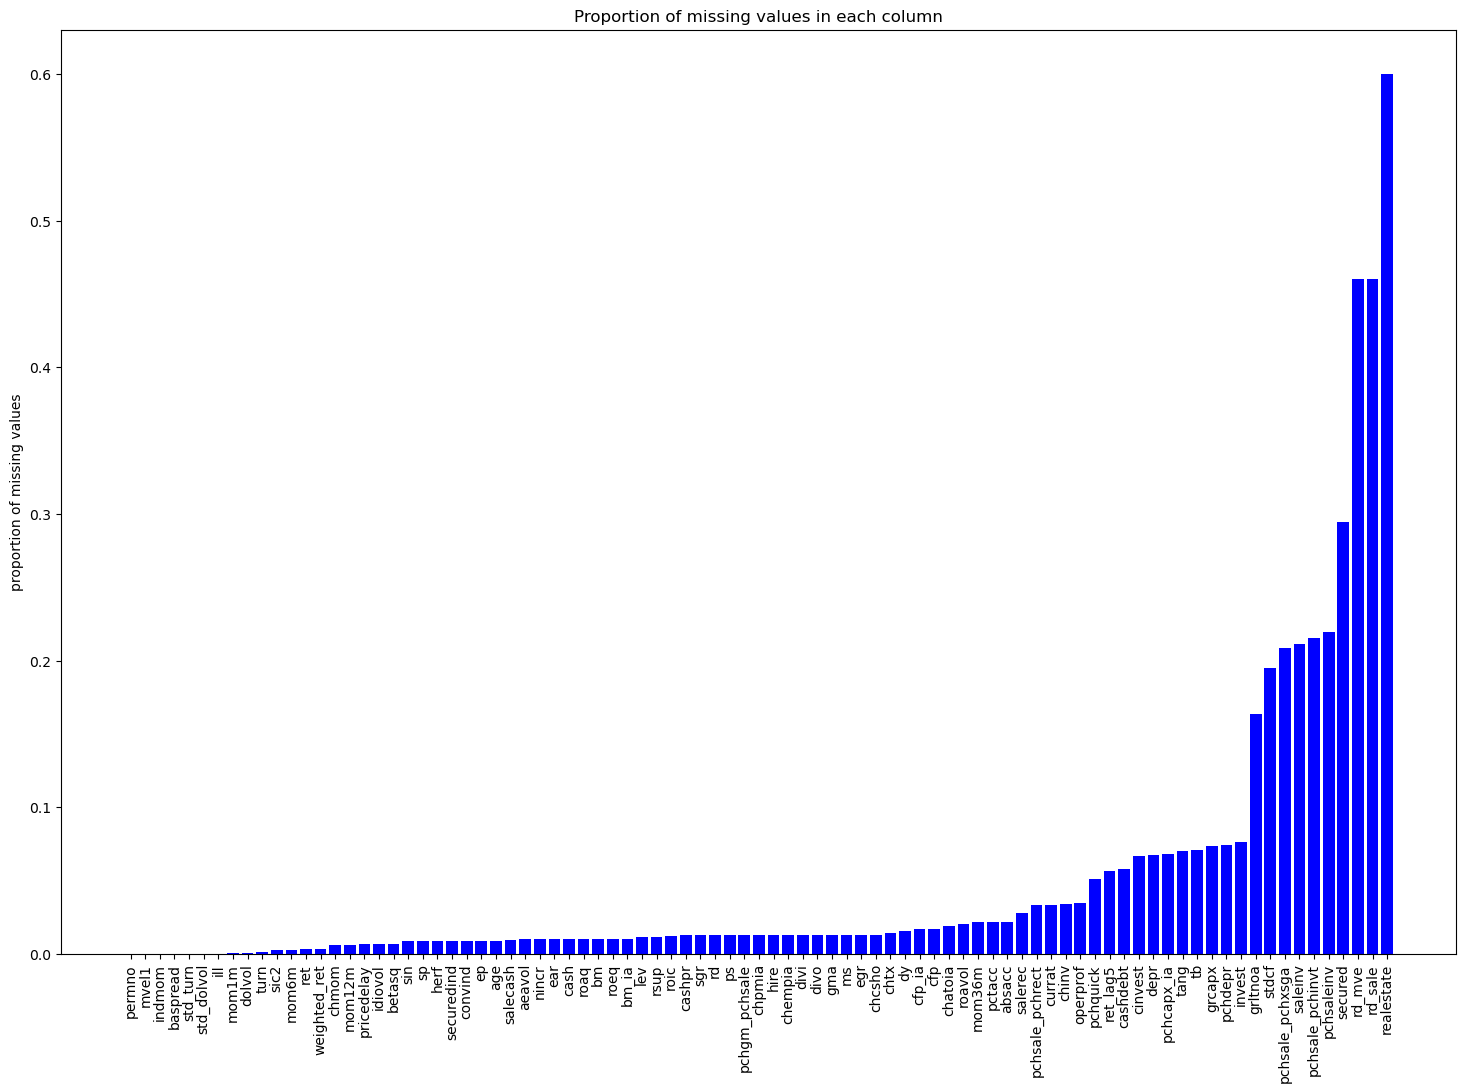

In [351]:
num_na = (df.isnull().sum() / len(df)).reset_index()
num_na.columns = ['field','proportion']
num_na = num_na.sort_values(by = 'proportion', ascending = True)
ind = np.arange(num_na.shape[0])
fig, ax = plt.subplots(figsize=(18,12))
rects = ax.bar(ind, num_na.proportion.values, color='blue')
ax.set_xticks(ind)
ax.set_xticklabels(num_na.field.values, rotation='vertical')
ax.set_ylabel("proportion of missing values")
ax.set_title("Proportion of missing values in each column")
plt.show()

In [361]:
print(num_na.shape[0])
num_na[num_na.iloc[:,1]<0.1]

87


field  proportion
0     permno    0.000000
1      mvel1    0.000000
6     indmom    0.000000
79  baspread    0.000000
82  std_turn    0.000037
..       ...         ...
65      tang    0.070015
66        tb    0.070701
35    grcapx    0.073643
43   pchdepr    0.073942
39    invest    0.076523

[77 rows x 2 columns]